# Initial Data Cleaning and Preprocessing
The following steps were conducted to clean the data and prepare it for further analysis.

1. Remove Duplicates: Check and remove any duplicate rows

2. Duplicate Check: The Customer ID column was reviewed for duplicate entries to ensure the uniqueness of each customer record.

3. Handling Missing Values: Null values were examined across all columns. Only the Churn Reason and Total Charges columns had missing data. Where Churn Value =0 and Churn Reason was missing, the value was updated to "Not Applicable".

4. Zero Tenure Adjustment: Customers with a tenure of 0 months had missing values in the Total Charges column. For consistency, these values were imputed as 0 and the Total Charges column was converted to numeric.

5. Standardizing Categorical Values: To streamline analysis, categorical values such as "No internet service" and "No phone service" were standardized and replaced with "No".

6. Churn Reason Mapping: Churn reasons were grouped into broader, more interpretable categories to simplify analysis and visualization. New groupings include groups like Competition, Pricing, Service Issues, Customer Service, Other, and Not Applicable.

7. Outlier Detection: Outliers were assessed using box plots and the Interquartile Range (IQR) method for key numerical columns including Monthly Charges, Total Charges, Customer Lifetime Value (CLTV), and Tenure Months. No significant outliers were found, so no data points were removed.

8. Feature Engineering: New features were derived to enhance the dataset, including:

    * Average Monthly Spend: Total Charges divided by Tenure Months for customers with tenure > 0.

    * High Value Customer: Customers with CLTV in the top 25% were labeled as “Yes”.

    * Customer Tenure Group: Customers were classified as "Short Term" (0–12 months), "Medium Term" (13–48 months), or "Long Term" (49–72 months).

    * Service Utilization: Counted the number of internet services marked "Yes"; labeled as “Multiple” if more than 2, otherwise “Few”.

    * Streaming Services: A binary feature indicating if the customer subscribed to either Streaming TV or Streaming Movies.

    * Electronic Check User: Flagged customers who used "Electronic check" as a payment method (associated with higher churn).

    * Autopay User: Identified customers using auto-payment methods such as "Bank transfer (automatic)" or "Credit card (automatic)".

    * Support Score: Tallied the number of support services (Online Security, Device Protection, Tech Support) each customer used.

9. Final Dataset Structuring:
The DataFrame columns were reordered to group related attributes and engineered features meaningfully. This helps with readability and downstream modeling.

10. Exporting Cleaned Data:
The cleaned dataset was exported as EDA_telco_data_v2.csv for further analysis and model building.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             log_loss, matthews_corrcoef)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

Number of duplicate customerIDs: 0

Null values per column:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64


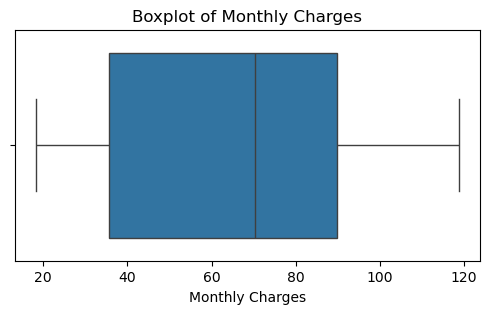

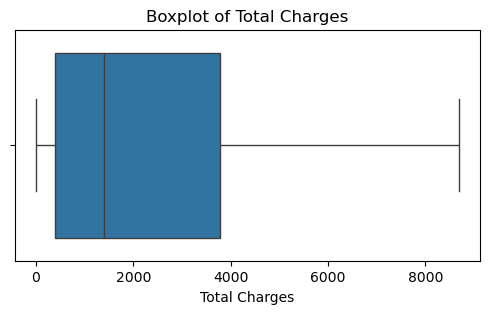

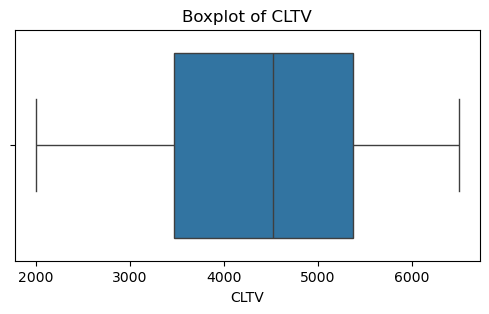

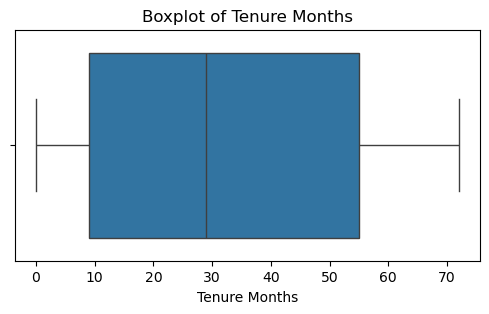


IQR Outlier counts:
Monthly Charges: 0 outliers
Total Charges: 0 outliers
CLTV: 0 outliers
Tenure Months: 0 outliers


In [ ]:
df = pd.read_csv('telco.csv')

# 1. Check for and remove Duplicate Rows
df.drop_duplicates()

# 2. Check for duplicate customer IDs
duplicates = df['CustomerID'].duplicated().sum()
print(f"Number of duplicate customerIDs: {duplicates}")

# 3. Null values per column
null_counts = df.isnull().sum()
print("\nNull values per column:\n", null_counts)

### Create cleaned churn reason column
# If Churn == 0 and Churn Reason is null, set to "Not Applicable"
df['Churn Reason Cleaned'] = np.where(
    (df['Churn Value'] == 0) & (df['Churn Reason'].isna()),
    'Not Applicable',
    df['Churn Reason']
)

### 4. Assigning a total charge of 0 to customers with a tenure of 0
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df.loc[(df['Tenure Months'] == 0) & (df['Total Charges'].isna()), 'Total Charges'] = 0


### 5. Replace 'No internet service' with 'No' for certain columns
internet_service_cols = [
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]
df[internet_service_cols] = df[internet_service_cols].replace('No internet service', 'No')


### Replace 'No phone service' with 'No' for Multiple Lines column
multiple_lines_cols = ['Multiple Lines']
df[multiple_lines_cols] = df[multiple_lines_cols].replace('No phone service', 'No')


### 6. Map cleaned churn reasons to broader categories
reason_map = {
    'Competitor made better offer': 'Competition',
    'Competitor had better devices': 'Competition',
    'Competitor offered higher download speeds': 'Competition',
    'Competitor offered more data': 'Competition',
    'Moved': 'Other',
    'Deceased': 'Other',
    "Don't know": 'Other',
    'Price too high': 'Pricing',
    'Extra data charges': 'Pricing',
    'Long distance charges': 'Pricing',
    'Product dissatisfaction': 'Service Issues',
    'Service dissatisfaction': 'Service Issues',
    'Network reliability': 'Service Issues',
    'Limited range of services': 'Service Issues',
    'Lack of affordable download/upload speed': 'Service Issues',
    'Lack of self-service on Website': 'Customer Service',
    'Poor expertise of online support': 'Customer Service',
    'Poor expertise of phone support': 'Customer Service',
    'Attitude of service provider': 'Customer Service',
    'Attitude of support person': 'Customer Service',
    'Not Applicable': 'Not Applicable'
}
df['Churn Reason Grouped'] = df['Churn Reason Cleaned'].map(reason_map)


### Create cleaned churn reason column
# If Churn == 0 and Churn Reason is null, set to "Not Applicable"
df['Churn Reason Cleaned'] = np.where(
    (df['Churn Value'] == 0) & (df['Churn Reason'].isna()),
    'Not Applicable',
    df['Churn Reason']
)


### 7. Check for outliers using the IQR Box Plot Method
key_columns = ['Monthly Charges', 'Total Charges', 'CLTV', 'Tenure Months']
outlier_counts = {}

for col in key_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

    # Boxplot
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

print("\nIQR Outlier counts:")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

In [ ]:
# 8 Feature Engineering

# Derived Feature 1 - Average Monthly Spend
df['Avg Monthly Spend'] = np.where(
    df['Tenure Months'] > 0,
    df['Total Charges'] / df['Tenure Months'],
    df['Total Charges']
)

# Derived Feature 2- High Value Customer as Yes/No
cltv_75 = df['CLTV'].quantile(0.75)
df['High Value Customer'] = np.where(df['CLTV'] > cltv_75, 'Yes', 'No')

# Derived Feature 3 - Short Term, Medium Term, and Long Term Customer
df['Customer Tenure Group'] = pd.cut(
    df['Tenure Months'],
    bins=[0, 12, 48, 72],
    labels=['Short Term', 'Medium Term', 'Long Term'],
    include_lowest=True
)

# Derived Feature 4: Service Utilization

# Define service columns with Yes/No values
service_cols = [
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

# Count how many services are "Yes"
df['Num Services Used'] = df[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

# Classify as "Multiple" if more than 2 services, else "Few"
df['Service Utilization'] = np.where(df['Num Services Used'] > 2, 'Multiple', 'Few')


# Derived Feature 5: To consolidate Streaming Services under one binary variable
df['Streaming Services'] = df.apply(
    lambda row: 'Yes' if (row['Streaming TV'] == 'Yes' or row['Streaming Movies'] == 'Yes') else 'No',
    axis=1
)

# Derived Feature 6: A feature to isolate the electronic Check User, a customer with a high chance of churn
import pandas as pd
df['Electronic Check User'] = df['Payment Method'].apply(lambda x: 1 if x == 'Electronic check' else 0)


# Derived Feature 7: Create a feature for payment methods that suggest automated billing:
autopay_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
df['Autopay User'] = df['Payment Method'].apply(lambda x: 1 if x in autopay_methods else 0)

# Derived Feature 8: A feature to measure the amount of support a customer has:
df['Support Score'] = df[['Tech Support', 'Device Protection', 'Online Security']].apply(lambda row: sum(row == 'Yes'), axis=1)

In [3]:
### 9. Final Handling of the dataset
desired_order = [
    'CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
    'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Contract', 'Paperless Billing', 'Payment Method', 'Tenure Months', 'Monthly Charges', 'Total Charges',
    'Avg Monthly Spend', 'Churn Score', 'Churn Label', 'Churn Value', 'CLTV', 'Customer Tenure Group',
    'High Value Customer', 'Service Utilization','Churn Reason', 'Churn Reason Cleaned', 'Churn Reason Grouped', 'Streaming Services',
    'Electronic Check User', 'Autopay User','Support Score'
]

# Reorder the DataFrame
df = df[desired_order]


### 10. Export cleaned data to CSV
df.to_csv('EDA_telco_data_v2.csv', index=False)
print("Cleaned data has been saved to 'EDA_telco_data_v2.csv'")

Cleaned data has been saved to 'EDA_telco_data_v2.csv'


# Data Preprocessing for Machine Learning
The dataset underwent a series of transformations to prepare it for predictive modeling. The following preprocessing steps were implemented:

1. Binary Label Encoding:
Binary categorical columns (e.g., Gender, Partner, Online Security) were label encoded using LabelEncoder, converting values such as "Yes"/"No" or "Male"/"Female" into numerical 0/1 values. This included both original and derived binary features like High Value Customer and Streaming Services.

2. One-Hot Encoding for Multi-Class Features:
Columns with more than two unique categories, such as Internet Service, Contract, Payment Method, and the grouped Churn Reason, were transformed using one-hot encoding. This expanded each feature into multiple binary columns while avoiding multicollinearity by dropping the first category from each.

3. Target Variable Separation:
The Churn Value column (0 = No churn, 1 = Churn) was saved as the target variable y before further feature removal.

4. Clustering Profile Dataset Saved:
A snapshot of the dataset (df_profile) was preserved before dropping important identifiers and churn-related columns. This preserved version is intended for unsupervised clustering analysis and customer profiling, and was exported as Clustering profile dataset.csv.

5. Dropping Irrelevant or Leakage Columns:
Columns not suitable for machine learning—such as identifiers (CustomerID), geolocation details, and target leakage features (Churn Label, Churn Reason, Churn Score, Churn Value)—were removed to prevent bias in model training. Billing-related columns (Monthly Charges, Total Charges, Tenure Months) were also excluded as they were already used to engineer other informative features.

6. Ensuring Numeric-Only Features:
After encoding, the dataset was inspected to ensure only numerical columns remained. Any leftover non-numeric columns were dropped to guarantee compatibility with ML algorithms.

7. Export for Modeling:
The final, numeric-only dataset was exported as MachineLearning_telco_data.csv further use.

In [ ]:
# Load data
df = pd.read_csv('EDA_telco_data_v2.csv')

# Define any missing column groups (update if needed)
internet_service_cols = ['Internet Service Type']
multiple_lines_cols = ['Multiple Lines']

### 1. Apply Label Encoding to binary columns
label_cols = [
    'Gender', 'Senior Citizen', 'Partner', 'Dependents',
    'Phone Service', 'Paperless Billing', 'Churn Label',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Customer Tenure Group', 'High Value Customer', 'Service Utilization',
    'Streaming Services'
] + internet_service_cols + multiple_lines_cols

### New Features Electronic Check User, Autopay User, Support Score are already numerically encoded

le = LabelEncoder()
for col in label_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

### 2. Apply One-Hot Encoding to multi-category columns
one_hot_cols = [
    'Internet Service', 'Contract',
    'Payment Method', 'Churn Reason Grouped'
]

df = pd.get_dummies(df, columns=[col for col in one_hot_cols if col in df.columns], drop_first=True)


### 3. Save target before dropping it
y = df['Churn Value']

### 4. Save a copy of the original data for cluster profiling
df_profile = df.copy()

# Convert bool columns to int
for col in df_profile.select_dtypes('bool').columns:
    df_profile[col] = df_profile[col].astype(int)
df_profile.to_csv('Clustering profile dataset.csv', index=False)

### 5. Drop all other unnecessary columns
drop_cols = [
    'CustomerID', 'Lat Long', 'Country', 'State', 'City', 'Zip Code', 'Latitude','Longitude','Count',
    'Churn Reason', 'Churn Reason Cleaned', 'Churn Label', 'Churn Score', 'Churn Value', 'Tenure Months', 'Monthly Charges', 'Total Charges'
]

df = df.drop(columns=[col for col in drop_cols if col in df.columns])

### 6. Ensure only numeric data remains
non_numeric_cols = df.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print("Dropping non-numeric columns:", list(non_numeric_cols))
    df = df.drop(columns=non_numeric_cols)

### 7. Export cleaned data to CSV
df.to_csv('MachineLearning_telco_data.csv', index=False)
print("Cleaned data has been saved to 'MachineLearning_telco_data_v2.csv'")

Cleaned data has been saved to 'MachineLearning_telco_data_v2.csv'


# Feature Selection for Churn Prediction
To identify the most informative features for predicting customer churn, a combination of correlation analysis and mutual information (MI) scoring was performed:

1. Feature Set Definition:
The feature matrix X was defined as the cleaned, numeric-only dataset prepared for machine learning. The target variable y was the binary Churn Value.

2. Correlation Analysis:
Pearson correlation coefficients were calculated between each numeric feature and the target variable (Churn Value). This helped identify linear relationships between individual features and the likelihood of churn.

3. Mutual Information (MI) Scoring:
Mutual information scores were computed. Unlike correlation, MI captures both linear and non-linear dependencies between features and the target. This approach provides a broader understanding of feature importance beyond simple linear trends.

4. Combined Ranking:
The correlation coefficients and MI scores were combined into a single DataFrame to facilitate comparison. Features were sorted by mutual information to prioritize variables with the highest predictive value.

5. Top 20 Features Identified:
The 20 most informative features for churn prediction were selected based on their mutual information scores. These features represent a diverse mix of customer demographics, service usage, contract types, and billing patterns. These features will be used for cluster analysis.

In [ ]:
# Step 1: Set X to the current df (features only)
X = df.copy()

# Step 2: Compute correlation with Churn (only for numeric features)
numeric_cols = X.select_dtypes(include=['number']).columns
correlations = pd.concat([X[numeric_cols], y], axis=1).corr()['Churn Value'].drop('Churn Value').sort_values(ascending=False)

# Step 3: Compute Mutual Information scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Step 4: Combine results
feature_scores = pd.DataFrame({
    'Correlation with Churn': correlations,
    'Mutual Information': mi_series
}).sort_values(by='Mutual Information', ascending=False)

# Step 5: Display top features
print(feature_scores)

                                        Correlation with Churn  \
Churn Reason Grouped_Not Applicable                        NaN   
Churn Reason Grouped_Customer Service                      NaN   
Churn Reason Grouped_Service Issues                        NaN   
Contract_Two year                                          NaN   
Customer Tenure Group                                 0.340018   
Internet Service_Fiber optic                               NaN   
Payment Method_Electronic check                            NaN   
Electronic Check User                                 0.301919   
Churn Reason Grouped_Other                                 NaN   
Churn Reason Grouped_Pricing                               NaN   
Internet Service_No                                        NaN   
Dependents                                           -0.248542   
Avg Monthly Spend                                     0.193301   
Paperless Billing                                     0.191825   
Autopay Us

In [6]:
# Save top 20 feature names
top_features = feature_scores.head(20)
top_features

,Correlation with Churn,Mutual Information
Churn Reason Grouped_Not Applicable,NaN,0.579664
Churn Reason Grouped_Customer Service,NaN,0.089367
Churn Reason Grouped_Service Issues,NaN,0.077095
Contract_Two year,NaN,0.067010
Customer Tenure Group,0.340018,0.060312
Internet Service_Fiber optic,NaN,0.052481
Payment Method_Electronic check,NaN,0.048697
Electronic Check User,0.301919,0.043333
Churn Reason Grouped_Other,NaN,0.038560
Churn Reason Grouped_Pricing,NaN,0.037867


In [7]:
# Get data types of the top 20 features
top_features_dtypes = df[feature_scores.head(20).index.tolist()].dtypes
print(top_features_dtypes)

Churn Reason Grouped_Not Applicable          bool
Churn Reason Grouped_Customer Service        bool
Churn Reason Grouped_Service Issues          bool
Contract_Two year                            bool
Customer Tenure Group                       int32
Internet Service_Fiber optic                 bool
Payment Method_Electronic check              bool
Electronic Check User                       int64
Churn Reason Grouped_Other                   bool
Churn Reason Grouped_Pricing                 bool
Internet Service_No                          bool
Dependents                                  int32
Avg Monthly Spend                         float64
Paperless Billing                           int32
Autopay User                                int64
Support Score                               int64
Online Security                             int32
Payment Method_Credit card (automatic)       bool
Contract_One year                            bool
Tech Support                                int32


# Unsupervised Learning Approach
After completing the necessary preprocessing steps, the data was prepared for clustering. The most important features were selected based on the feature selection. All Boolean columns were converted to numerical columns to ensure compatibility with clustering algorithms and all numerical columns were standardized to prevent features with larger ranges from dominating the clustering process.

A correlation matrix was also computed, and pairs of features with an absolute correlation value greater than 0.8 were identified. The features Electronic Check User and Payment Method_Electronic check were found to be perfectly correlated feature pairs. Only this feature pair was highly correlated,  suggesting that dimensionality reduction through PCA was not strictly necessary. As such, one feature from the feature pair Payment Method_Electronic check was removed.

However, PCA was still tested as an optional preprocessing step to reduce dimensionality and improve clustering performance. Results indicated that clustering performed better without PCA, likely due to the retention of the original feature space, which preserved more meaningful variation for clustering.

In [ ]:
# Load data
df = pd.read_csv('MachineLearning_telco_data.csv')

# Get the selected top features
X_selected = df[top_features.index]

# Convert bool columns to int
for col in df.select_dtypes('bool').columns:
    df[col] = df[col].astype(int)

# Confirm all numeric features
print(df.dtypes.value_counts())

# Select all numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Scale numeric features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=X_selected.columns)

# Create correlation matrix
corr_matrix = df_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
high_corr_pairs = [(col, row, upper.loc[row, col]) for col in upper.columns for row in upper.index if upper.loc[row, col] > 0.8]

# Sort by correlation strength
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: -x[2])

# Display
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

# Display and handle highly correlated features
features_to_drop = set()
for feature1, feature2, corr_value in high_corr_pairs:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        # Decide to drop feature2
        features_to_drop.add(feature2)
        print(f"Feature '{feature2}' was deleted because it is highly correlated with '{feature1}' (correlation: {corr_value:.2f})")

# Drop highly correlated features
df_scaled.drop(columns=features_to_drop, inplace=True)

print(f"Remaining features: {df_scaled.columns.tolist()}")


int64      21
int32      12
float64     1
Name: count, dtype: int64
Electronic Check User and Payment Method_Electronic check: 1.00
Feature 'Payment Method_Electronic check' was deleted because it is highly correlated with 'Electronic Check User' (correlation: 1.00)
Remaining features: ['Churn Reason Grouped_Not Applicable', 'Churn Reason Grouped_Customer Service', 'Churn Reason Grouped_Service Issues', 'Contract_Two year', 'Customer Tenure Group', 'Internet Service_Fiber optic', 'Electronic Check User', 'Churn Reason Grouped_Other', 'Churn Reason Grouped_Pricing', 'Internet Service_No', 'Dependents', 'Avg Monthly Spend', 'Paperless Billing', 'Autopay User', 'Support Score', 'Online Security', 'Payment Method_Credit card (automatic)', 'Contract_One year', 'Tech Support']


# K-Means Clustering
This was the first clustering algorithim attempted. First the optimal k was identified using both the Elbow Method and Silhoutte Scores. The elbow method identified K=3 as the optimal ponit however, when compared to Silhoutte Score, although there is a peak at K=3, the highest peaks occur at K=8 and K = 9.

As such K=3, K=8 and K=9 were evaluated

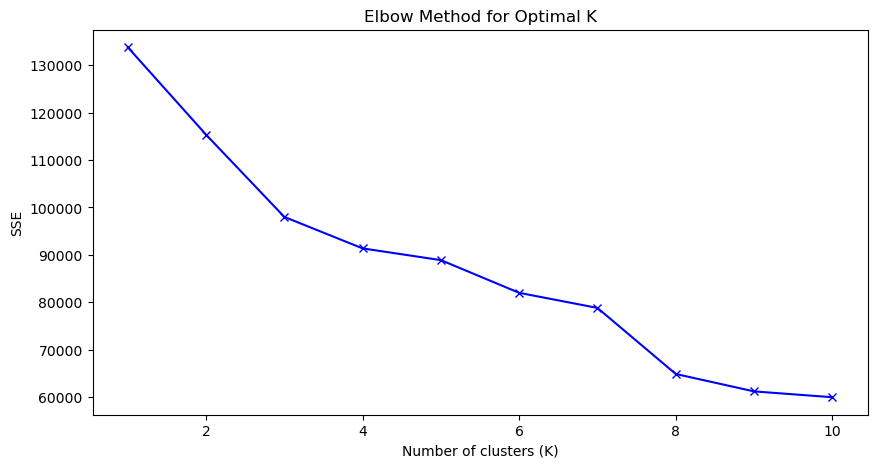

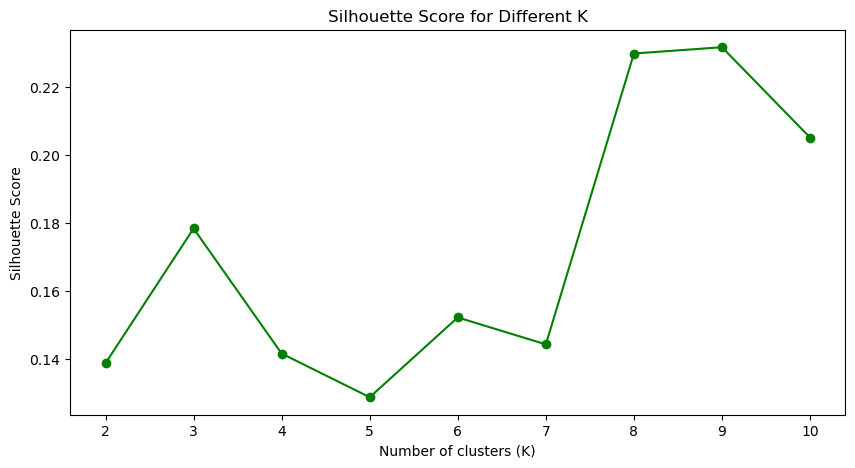

In [9]:
sse = []
silhouette_scores = []
K_elbow = range(1, 11)
K_silhouette = range(2, 11)

# Elbow method (including K=1)
for k in K_elbow:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# Silhouette scores
for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot SSE (Elbow)
plt.figure(figsize=(10,5))
plt.plot(K_elbow, sse, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10,5))
plt.plot(K_silhouette, silhouette_scores, 'go-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K')
plt.show()

# Final KMeans Model and Evaluation

K = 9 and K = 8 yielded higher Silhoutte Scores and lower Davies-Bouldin Index scores indicating better-defined and more separated clusters; however, K=3 provided more visually distinct clusters in the PCA scatter plot.

A detailed analysis of cluster profiles showed that K=3 oversimplified the segmentation, missing critical differences in churn rates, tenure ranges, and spending patterns. Meanwhile K=9 revealed deeper and more meaningful customer groupings without introducing redundancy providing more actionable insights for targeting strategies. Also, the higher Silhouette Score and lower Davies-Bouldin Index for K=9 indicates it is a more suitable choice for both customer profiling and subsequent supervised modeling.

KMeans K=9 - Silhouette Score: 0.2317
KMeans K=9 - Davies-Bouldin Index: 1.5089


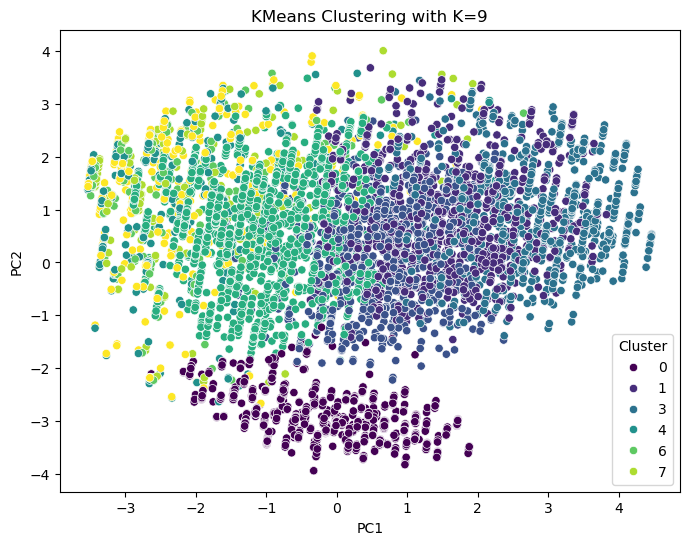

In [10]:
# Fit final KMeans
final_kmeans = KMeans(n_clusters=9, random_state=42)
clusters = final_kmeans.fit_predict(df_scaled)

# Attach to original dataframe
df['KMeans_Cluster'] = clusters
# Add cluster labels to df_profile
df_profile = df_profile.reset_index(drop=True)
df_profile['KMeans_Cluster'] = df['KMeans_Cluster']

# Evaluate clustering
sil_score = silhouette_score(df_scaled, clusters)
db_score = davies_bouldin_score(df_scaled, clusters)
print(f"KMeans K=9 - Silhouette Score: {sil_score:.4f}")
print(f"KMeans K=9 - Davies-Bouldin Index: {db_score:.4f}")

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

# Append cluster labels
df_viz = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_viz['Cluster'] = clusters

# Plot PCA scatter with cluster coloring
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('KMeans Clustering with K=9')
plt.show()


# Cluster Visualization

The PCA Scatterplot above showed showed limited separation between clusters, with noticeable overlap. However, this lack of distinct grouping may be attributed to PCA's linear nature, which may not capture complex, non-linear relationships within the data. As such a t-SNE plot was done to better assess potential non-linear separability.

The resulting plot below revealed improved separation, especially for high-risk churn segments (clusters 4,6,7,8). However, the other clusters are not compact and overlap still exists. This indicates that while some meaningful segmentation exists, the overall cluster structure is not fully compact or well-defined in low-dimensional space. This suggests that customer behavior may be inherently complex and may not form sharply bounded groups.

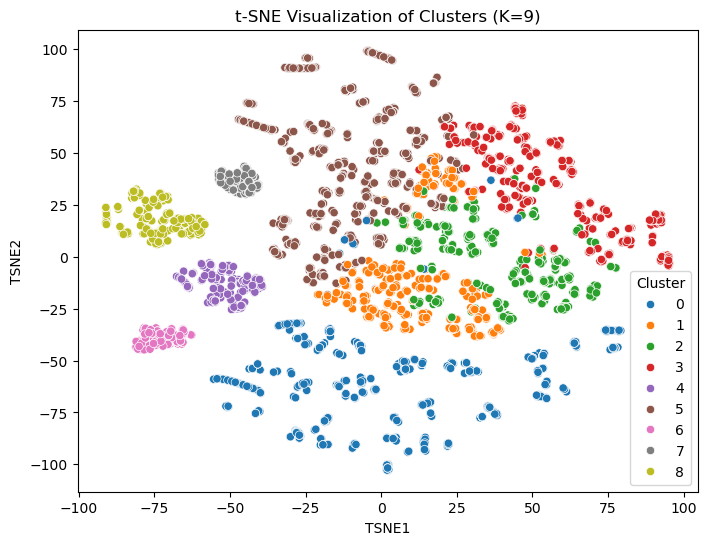

In [ ]:
# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(df_scaled)

# Create DataFrame for visualization
df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = clusters

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10')
plt.title('t-SNE Visualization of Clusters (K=9)')
plt.show()

# DBSCAN Clustering
DBSCAN clustering was then performed with an initial analysis of the K-distance graph, which suggested an optimal ϵ value between 1 and 3. However, ϵ=4.5 was selected as it yielded a higher Silhouette Score and reduced the number of noise points compared to the suggested range. Using this configuration, DBSCAN identified 3 clusters with 0 noise points. The visualization however, shows that clusters were not distinctly separated suggesting that DBSCAN might not fully capture the underlying structure of the data in this scenario.

As such, the model was reevaluated at ϵ=1, 1.5, 2.5, 3, 3.5 and 4 but this resulted in lower Silhouette Scores, higher noise and more fragmented clusters. Based on the visualizations, the clusters weren't distinctly separated either. Higher ϵ such as ϵ = 5 and 5.5 were also investigated but these all gave the same results as ϵ = 4.5. A detailed cluster profile anaysis showed that all ϵ values, regardless of the choice, led to the formation of one large cluster followed by smaller ones. This pattern suggested that DBSCAN was not the most suitable method for this dataset, as it failed to produce meaningful, well-separated clusters regardless of ϵ choice.

As a result, ϵ = 4.5 was taken as the most effective configuration for this dataset as it still yeilded the best Silhouette Score.

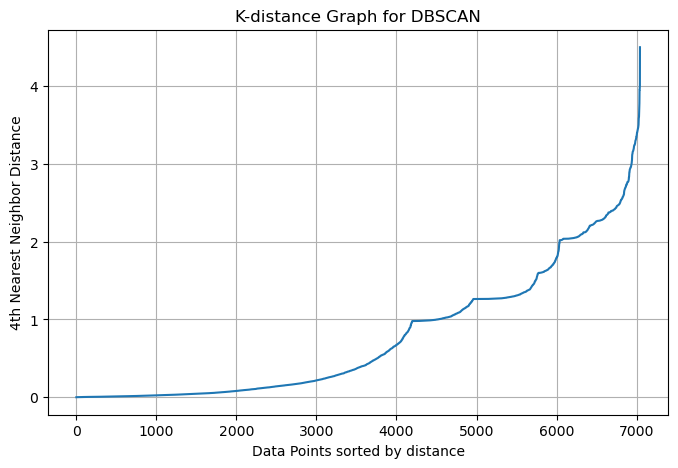

DBSCAN (eps=4.5) found 3 clusters and 0 noise points.
DBSCAN - Silhouette Score: 0.3038


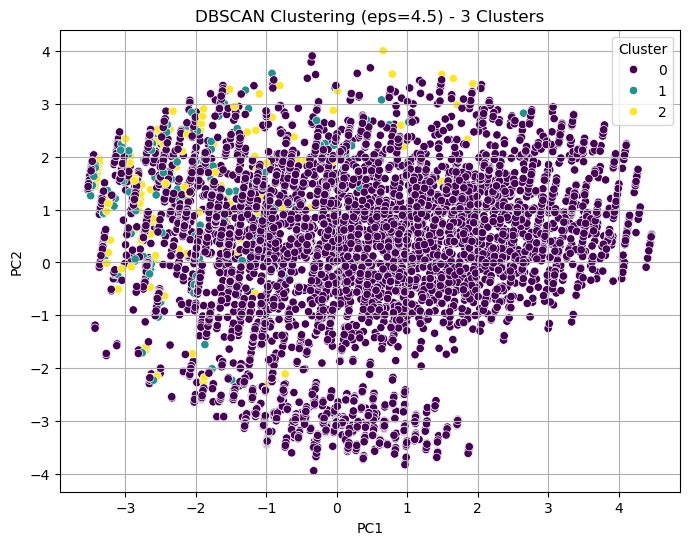

In [ ]:
# Estimate optimal epsilon
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:,4])

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('K-distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

# Apply DBSCAN with chosen eps
dbscan = DBSCAN(eps=4.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

# Add cluster labels to df_profile
df_profile['DBSCAN_Cluster'] = df['DBSCAN_Cluster']

# Cluster labels
labels = df['DBSCAN_Cluster']

# Count clusters (excluding noise points)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

# Evaluate Silhouette Score if valid
if n_clusters > 1:
    dbscan_silhouette = silhouette_score(df_scaled, labels)
    print(f"DBSCAN (eps=4.5) found {n_clusters} clusters and {n_noise} noise points.")
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print(f"DBSCAN (eps=4) found only one cluster.")

# Append cluster labels
df_viz = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_viz['Cluster'] = labels

# Plot PCA scatter with cluster coloring
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title(f'DBSCAN Clustering (eps=4.5) - {n_clusters} Clusters')
plt.grid(True)
plt.show()

# Agglomerative Hierarchical Clustering (AHC)
Agglomerative Hierarchical Clustering (AHC) was applied using Ward’s linkage method. The dendrogram was examined to determine an appropriate number of clusters, and t=5 was chosen as it aligned well with the natural divisions in the data. However visual representation showed a lack of distinct clusters. As such smaller clusters such as t = 3 and 4 were also evaluated but this resulted in lower Silhoutte Scores with little improvement in terms of visualization. Higher cluster counts, such as t=6 and 7, resulted in slightly higher Silhouette Score, but cluster profiling revealed that higher clusters like 7 were repetitive while smaller clusters like 3 oversimplified the segmentation. As such t =5 was chosen as it offered a better balance and more defined cluster insights.

The Cophenetic Correlation Coefficient (CCC) was calculated to assess the clustering quality, yielding a value of 0.5811. This indicated moderate consistency with the hierarchical structure.

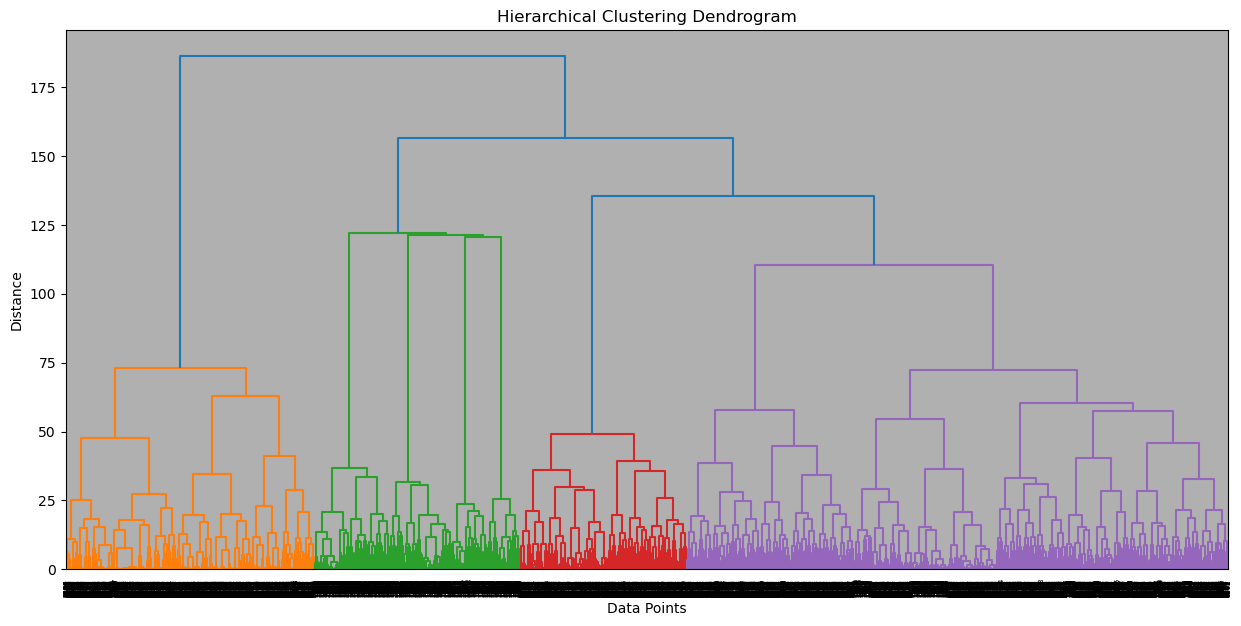

Cophenetic Correlation Coefficient: 0.5811
AHC found 5 clusters.
AHC - Silhouette Score: 0.1753


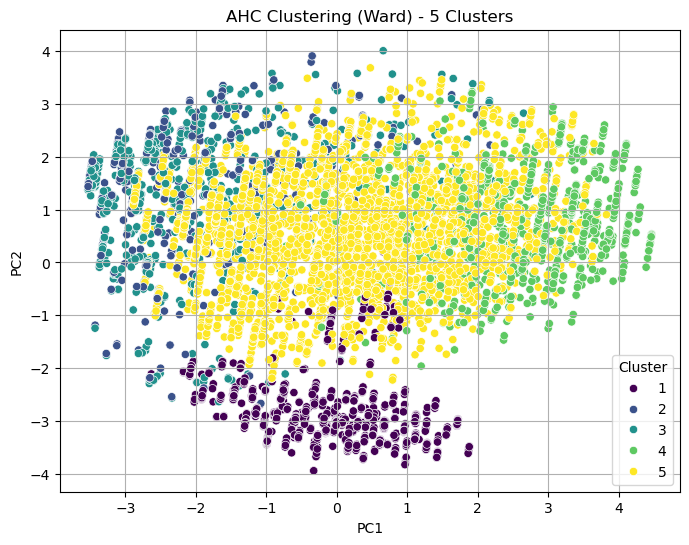

In [ ]:
# Create linkage matrix using Ward's method
linkage_matrix = linkage(df_scaled, method='ward')

# Plot Dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Calculate Cophenetic Correlation Coefficient
coph_corr, _ = cophenet(linkage_matrix, pdist(df_scaled))
print(f"Cophenetic Correlation Coefficient: {coph_corr:.4f}")

# Apply clustering with a chosen number of clusters
df['AHC_Cluster'] = fcluster(linkage_matrix, t=5, criterion='maxclust')

df_profile['AHC_Cluster'] = df['AHC_Cluster']

# Count clusters
n_ahc_clusters = len(set(df['AHC_Cluster']))

# Evaluate Silhouette Score if valid
if n_ahc_clusters > 1:
    ahc_silhouette = silhouette_score(df_scaled, df['AHC_Cluster'])
    print(f"AHC found {n_ahc_clusters} clusters.")
    print(f"AHC - Silhouette Score: {ahc_silhouette:.4f}")
else:
    print("AHC found only one cluster.")

# Create PCA scatterplot with AHC cluster labels
df_viz_ahc = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_viz_ahc['Cluster'] = df['AHC_Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_viz_ahc, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title(f'AHC Clustering (Ward) - {n_ahc_clusters} Clusters')
plt.grid(True)
plt.show()

# Comparing Models
Comparing the three clustering models, DBSCAN achieved the highest Silhouette Score, suggesting well-defined clusters. However, the visualizations indicated that DBSCAN might not be ideal for meaningful segmentation, as the clusters lacked clear separation. As such, a comprehensive analysis that includes cluster profiling must be conducted to evaluate the interpretability and relevance of each clustering method. This step ensures that the chosen cluster labels are robust and provide actionable insights to make them suitable for supervised learning models.

In [14]:
print(f"KMeans Silhouette: {sil_score}")
print(f"DBSCAN Silhouette: {dbscan_silhouette if len(set(labels)) > 1 else 'N/A'}")
print(f"AHC Silhouette: {ahc_silhouette}")

KMeans Silhouette: 0.23166381146482748
DBSCAN Silhouette: 0.30379511864496844
AHC Silhouette: 0.17532938117577476


# Cluster Profiling
The function below aggregates and summarizes cluster data by computing key metrics for each cluster. This includes average monthly spend, churn rate, CLTV, tenure, monthly charges, total charges, and churn score. It outputs a concise profile for each cluster, facilitating comparisons across the different segmentation methods.

## KMeans

#### Cluster 0 - Low Spenders, Very Low Churn, Medium Tenure (Low-Value Loyal)

Characteristics: very low Churn Rate (2%), low Churn Score (51.25), moderate CLTV (4377.88), medium Tenure (31.36 months), very low Monthly Charges (21.47), no Service Utilization, Autopay Users (44%) and no Churn Reasons

Profile: Represents cost-conscious customers with basic service plans. They are stable, loyal, and not at high risk of churning. They use minimal services and prefer a low-cost option.

#### Cluster 1 - Moderate Spenders, Low Churn, Mid-High Tenure (Value Seekers)

Characteristics: low Churn Rate (4%), low Churn Score (51.81), moderate-high CLTV (4548.29), mid-high Tenure (42.54 months), moderate-high Monthly Charges (76.17), high Service Utilization (79%), Autopay Users (54%) and no significant Churn Reasons

Profile: This group seeks higher value from their service plans. They utilize many services, stay for a long time, and have low churn risk. They may respond well to targeted upgrades or loyalty rewards.

#### Cluster 2 - Moderate Spenders, Moderate Churn, Moderate Tenure (At-Risk Users)

Characteristics: moderate Churn Rate (14%), moderate-high Churn Score (53.74), moderate CLTV (4362.74), moderate Tenure (33.02 months), moderate-high Monthly Charges (75.63), low-mid Service Utilization (39%), Autopay Users (100%) and no significant churn reason listed

Profile: Moderate-tenure customers who spend moderately but are at risk of churn. They may feel they are not getting full value or experience service issues. Retention efforts should focus on value and service improvements such as service quality guarantees or loyalty incentives.

### Cluster 3 - High Spenders, Very Low Churn, Long Tenure (High-Value Loyal)

Characteristics: very low Churn Rate (2%), very low Churn Score (50.58), high CLTV (5008.36), very long Tenure (61.16 months), high Monthly Charges ($84.33), very high Service Utilization (95%), Autopay Users (75%) and no significant Churn Reasons

Profile: High-value customers with extensive service usage and very low churn. They are very loyal and represent a core revenue source. Retention is less critical, but maintaining satisfaction is key. Ensure continued satisfaction through elite rewards or personalized service upgrades.

#### Cluster 4 - Low-Mid Spenders, Extremely High Churn, Short Tenure (Service-Disappointed)

Characteristics: extremely high Churn Rate (100%), very high Churn Score (82.47), moderate-low CLTV (4174.97), short Tenure (18.08 months), moderate-high Monthly Charges (73.24), low Service Utilization (35%), Autopay Users (23%) and primarily dissatisfied with Service Issues

Profile: Disengaged users who churn rapidly due to service dissatisfaction. Immediate improvements in service quality and experience are required to retain similar customers.

#### Cluster 5 - Low-Mid Spenders, Moderate Churn, Short Tenure (Churn-Prone)

Characteristics: moderate Churn Rate (26%), moderate-high Churn Score (58.56), moderate-low CLTV (4193.66), short Tenure (20.80 months), moderate-high Monthly Charges (73.34), low Service Utilization (29%), no Autopay Users and no significant Churn Reasons

Profile: Short-tenure, churn-prone customers who may need incentives to stay. Autopay adoption and targeted engagement such as discounts or onboarding support can help reduce churn.

#### Cluster 6 - Low Spenders, Extremely High Churn, Very Short Tenure (Disengaged Users)

Characteristics: extremely high Churn Rate (100%), very high Churn Score (81.61), low CLTV (4042.23), very short Tenure (17.19 months), moderate-high Monthly Charges (73.43), low Service Utilization (27%), Autopay Users (29%) and no significant Churn Reason

Profile: Disengaged from the start. Very short-tenured customers who leave quickly due to unmet expectations. Addressing service gaps and improving onboarding and engagement is essential for retention.

#### Cluster 7 - Moderate Spenders, Extremely High Churn, Short Tenure (Pricing-Sensitive)

Characteristics: extremely high Churn Rate (100%), very high Churn Score (82.96), moderate-low CLTV (4127.89), short Tenure (19.60 months), moderate-high Monthly Charges (77.34), low Service Utilization (34%), Autopay Users (33%) and dissatisfaction with Pricing Issues

Profile: Customers sensitive to pricing, leading to high churn. Pricing adjustments or better communication of value may improve retention. Try tiered pricing or customizable pricing solutions.

#### Cluster 8 - Low Spenders, Extremely High Churn, Very Short Tenure (Value-Dissatisfied)

Characteristics: extremely high Churn Rate (100%), very high Churn Score (82.79), low CLTV (4133.87), very short Tenure (17.15 months), moderate-high Monthly Charges (73.77), low Service Utilization (28%), Autopay Users (25%) and dissatisfaction with Customer Service Issues

Profile: Customers churn due to dissatisfaction with customer service. Investing in improved customer service quality and faster issue resolution can enhance retention rates.


## DBSCAN

#### Cluster 0 - Mid Spenders, Moderate Churn, Moderate Tenure (Stable Average Users)

Characteristics: moderate Churn Rate (22%), moderate Churn Score (57.24), moderate CLTV (4419.97), moderate Tenure (33.24 months), moderate Monthly Charges ($64.11), moderate Service Utilization (41%), Autopay Users (44%), minimal issues with Pricing (0%), minimal Service Issues (6%), and minimal Customer Service Issues (7%)

Profile: Represents the largest group of customers with stable usage patterns and moderate satisfaction. Churn risk exists but is not critical. Retention efforts should focus on personalized engagement to further enhance satisfaction and reduce churn.

#### Cluster 1 - Low Spenders, Extremely High Churn, Very Short Tenure (Service-Disappointed)
Characteristics: extremely high Churn Rate (100%), very high Churn Score (81.61), low CLTV (4042.23), very short Tenure (17.19 months), moderate-high Monthly Charges ($73.43), low Service Utilization (27%), Autopay Users (29%), and no significant issues with Pricing, Service, or Customer Service

Profile: Very short-tenure customers who quickly leave due to unmet expectations. This group highlights a need for improvements in onboarding, service offerings, and value communication to reduce early churn.

### Cluster 2 - Moderate Spenders, Extremely High Churn, Short Tenure (Pricing-Sensitive)
Characteristics: extremely high Churn Rate (100%), very high Churn Score (82.96), moderate-low CLTV (4127.89), short Tenure (19.60 months), moderate-high Monthly Charges ($77.34), low Service Utilization (34%), Autopay Users (33%), dissatisfaction with Pricing Issues (100%), and no significant Service or Customer Service Issues

Profile: Customers with short tenure and very high churn, primarily due to pricing dissatisfaction. Addressing pricing concerns through flexible plans, discounts, or better communication of value is crucial to retaining similar customers.

Cluster 0 accounts for the vast majority of customers (6631), making the segmentation less effective for actionable insights as it overshadows the smaller, high-churn clusters (clusters 1 and 2). This segmentation is less suitable for this dataset.

## AHC

#### Cluster 1 - Low Spenders, Very Low Churn, Moderate Tenure (Low-Value Loyal)

Characteristics: very low Churn Rate (3%), very low Churn Score (51.28), moderate-low CLTV (4371.77), moderate Tenure (31.20 months), very low Monthly Charges ($22.12), negligible Service Utilization (1%), moderate Autopay Users (47%), and no significant Pricing, Service, or Customer Service Issues

Profile: Represents cost-conscious, stable customers with basic service plans. They are low-value yet loyal, with minimal churn risk. Focus on maintaining satisfaction with affordable options to retain these customers.

#### Cluster 2 - Moderate Spenders, Extremely High Churn, Very Short Tenure (Pricing-Sensitive)

Characteristics: extremely high Churn Rate (100%), very high Churn Score (82.81), moderate-low CLTV (4142.86), very short Tenure (17.37 months), moderate Monthly Charges ($73.85), low Service Utilization (28%), low Autopay Users (26%), and significant Customer Service Issues

Profile: Represents customers who quickly leave due to unmet expectations. These customers highlight a critical need to enhance the initial customer experience and communicate value more effectively to reduce churn.

#### Cluster 3 - Moderate Spenders, Extremely High Churn, Short Tenure (Service-Concerned)

Characteristics: extremely high Churn Rate (100%), very high Churn Score (82.36), moderate-low CLTV (4129.35), short Tenure (18.29 months), moderate Monthly Charges ($74.31), low Service Utilization (33%), low Autopay Users (27%), moderate dissatisfaction with Pricing Issues (25%), and significant Service Issues (48%)

Profile: Customers leaving due to dissatisfaction with service quality. Service improvements, proactive communication, and issue resolution could significantly enhance retention rates.

#### Cluster 4 - High Spenders, Very Low Churn, Long Tenure (High-Value Loyal)

Characteristics: very low Churn Rate (1%), very low Churn Score (50.38), high CLTV (5020.32), long Tenure (61.56 months), high Monthly Charges ($84.04), very high Service Utilization (92%), high Autopay Users (76%), and no significant Pricing, Service, or Customer Service Issues

Profile: Represents long-tenured, high-value customers who are loyal and deeply engaged with services. These customers are a critical asset and should be prioritized for loyalty rewards and personalized offers to ensure continued satisfaction.

#### Cluster 5 - Moderate Spenders, Moderate Churn, Moderate Tenure (Average Users)

Characteristics: moderate Churn Rate (17%), moderate Churn Score (55.60), moderate CLTV (4324.70), moderate Tenure (29.45 months), moderate Monthly Charges ($74.88), moderate Service Utilization (46%), moderate Autopay Users (39%), and no significant Pricing, Service, or Customer Service Issues

Profile: Represents the largest group with average usage patterns and moderate churn risk. This group would benefit from engagement strategies such as value-added services or targeted discounts to enhance satisfaction and reduce churn.


In [15]:
def profile_clusters(df_profile, cluster_col):
    """
    Profiles clusters in a dataframe based on a cluster label column.

    Parameters:
        df_profile (pd.DataFrame): The dataframe containing customer info and cluster labels.
        cluster_col (str): The name of the column containing cluster labels.

    Returns:
        pd.DataFrame: Aggregated cluster profiles.
    """
    profile = df_profile.groupby(cluster_col).agg({
        'CustomerID': 'count',  # Cluster size
        'Churn Value': 'mean',  # Churn rate
        'Churn Score': 'mean',  # Average churn score
        'CLTV': 'mean',  # Customer Lifetime Value
        'Tenure Months': 'mean',  # Average tenure
        'Monthly Charges': 'mean',  # Average monthly charges
        'Total Charges': 'mean',  # Total charges
        'Service Utilization': 'mean',  # Engagement with services
        'Support Score': 'mean',  # Support satisfaction
        'Streaming Services': 'mean',  # Percentage using streaming services
        'Autopay User': 'mean',  # Percentage using autopay
        'Churn Reason Grouped_Pricing': 'mean',  # Pricing-related churn
        'Churn Reason Grouped_Service Issues': 'mean',  # Service issue-related churn
        'Churn Reason Grouped_Customer Service': 'mean' # Customer service -related churn
    }).rename(columns={
        'CustomerID': 'Count',
        'Churn Value': 'Churn Rate'
    }).round(2)

    return profile

kmeans_profile = profile_clusters(df_profile, 'KMeans_Cluster')
dbscan_profile = profile_clusters(df_profile, 'DBSCAN_Cluster')
ahc_profile = profile_clusters(df_profile, 'AHC_Cluster')

# View cluster profiles
print("KMeans Profile:\n", kmeans_profile)
print("\nDBSCAN Profile:\n", dbscan_profile)
print("\nAHC Profile:\n", ahc_profile)

KMeans Profile:
                 Count  Churn Rate  Churn Score     CLTV  Tenure Months  \
KMeans_Cluster                                                           
0                1479        0.02        51.25  4377.88          31.36   
1                 881        0.04        51.81  4548.29          42.54   
2                 877        0.14        53.74  4362.74          33.02   
3                 984        0.02        50.58  5008.36          61.16   
4                 381        1.00        82.47  4174.97          18.08   
5                1577        0.26        58.56  4193.66          20.80   
6                 213        1.00        81.61  4042.23          17.19   
7                 199        1.00        82.96  4127.89          19.60   
8                 452        1.00        82.79  4133.87          17.15   

                Monthly Charges  Total Charges  Service Utilization  \
KMeans_Cluster                                                        
0                         

Based on the Silhoutte Scores comparison, the visualizations and the cluster profiles analysis, K Means seems like the best clustering method. As such, we will keep the K-Means Cluster Lables for supervised Learning models and we will remove the other cluster labels.

First we will do a visual representation of each of the 9 clusters given by the KMeans method.

We will also do a heatmap of the different features across the 9 clusters

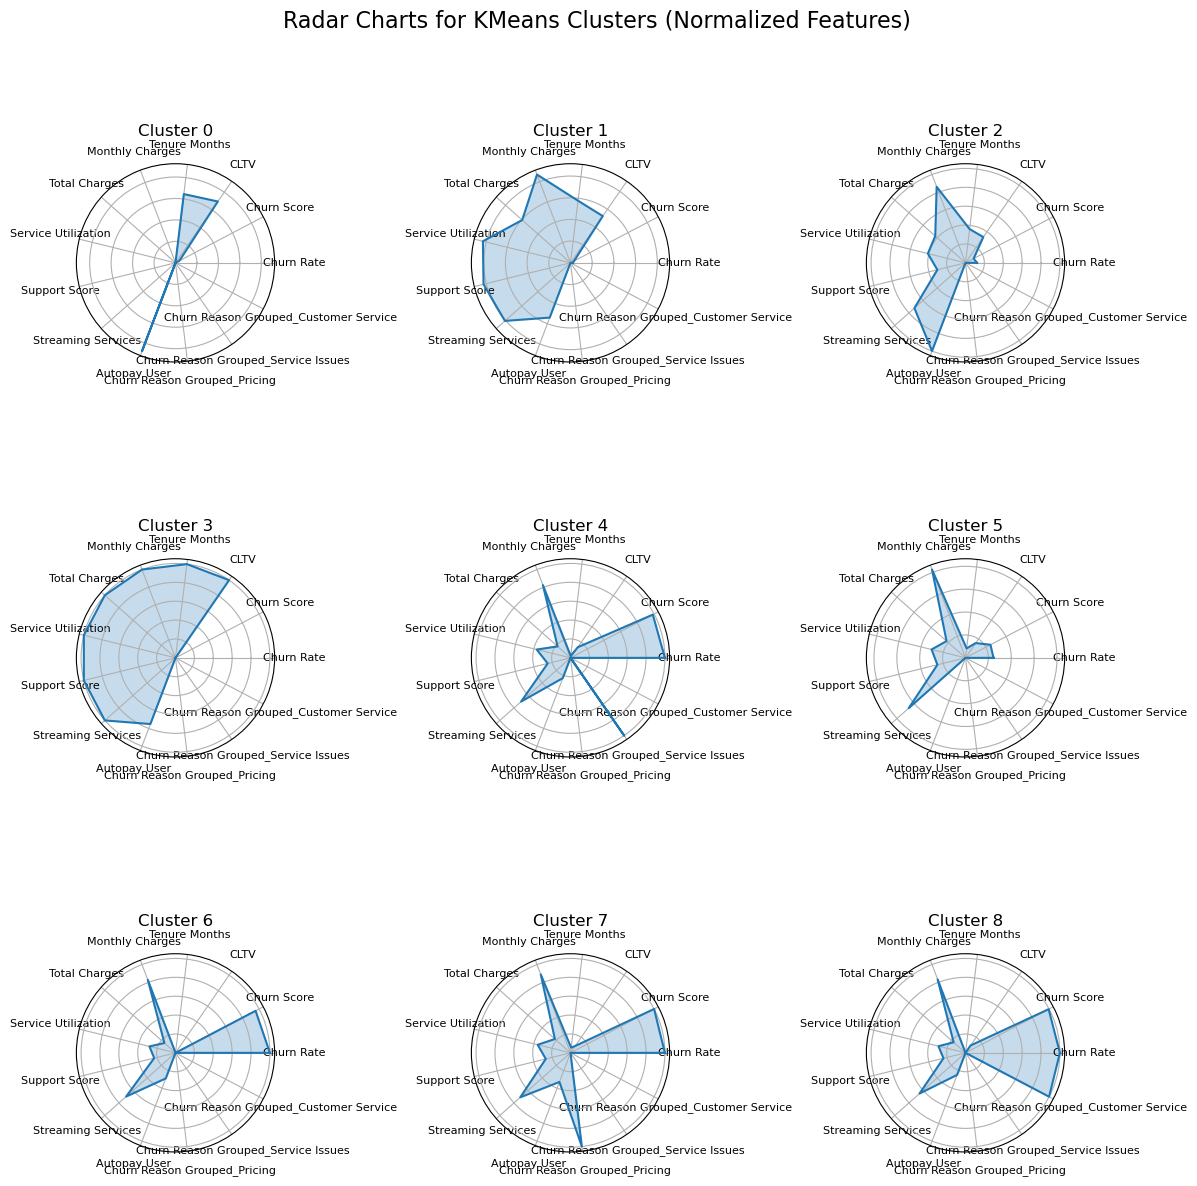

In [ ]:
# Normalize features for radar chart
features = kmeans_profile.columns.drop('Count')
normalized = MinMaxScaler().fit_transform(kmeans_profile[features])
kmeans_profile_norm = pd.DataFrame(normalized, columns=features, index=kmeans_profile.index)

# Radar chart for each cluster
labels = features.tolist()
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # repeat first angle to close loop

plt.figure(figsize=(12, 12))
for i, row in kmeans_profile_norm.iterrows():
    values = row.tolist()
    values += values[:1]  # repeat first value to close loop
    ax = plt.subplot(3, 3, i + 1, polar=True)
    ax.plot(angles, values, linewidth=1.5)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f'Cluster {i}', size=12, y=1.1)
    ax.set_xticks(angles[:-1])  # only set original angles
    ax.set_xticklabels(labels, fontsize=8)  # only original labels
    ax.set_yticklabels([])

plt.tight_layout()
plt.suptitle('Radar Charts for KMeans Clusters (Normalized Features)', y=1.03, fontsize=16)
plt.show()

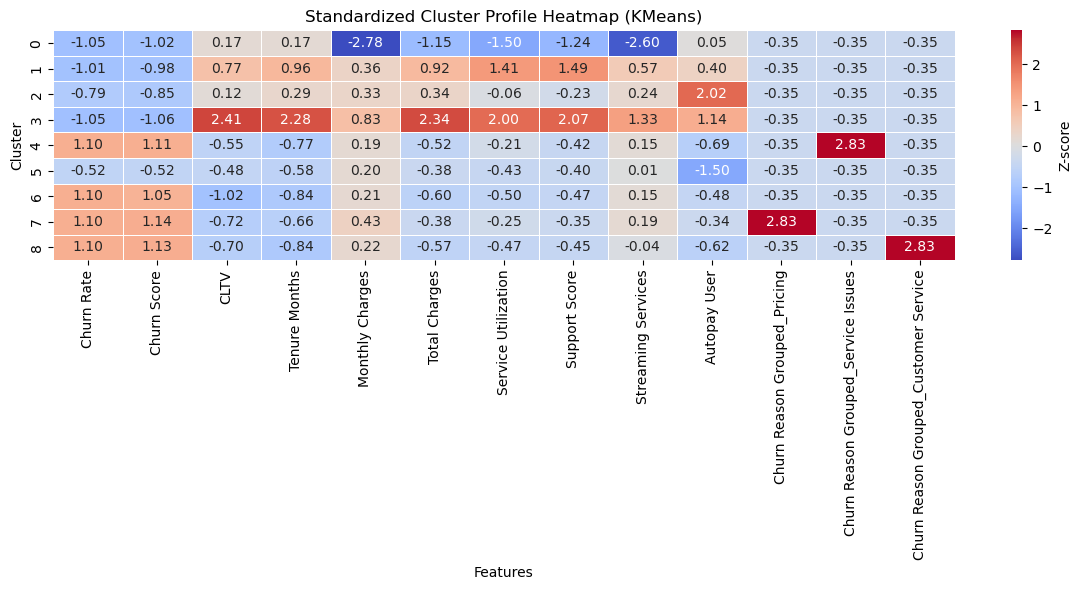

In [17]:
# Drop 'Count' before scaling
features_to_scale = kmeans_profile.drop(columns=['Count'])

# Standardize
scaler = StandardScaler()
profile_scaled = pd.DataFrame(
    scaler.fit_transform(features_to_scale),
    columns=features_to_scale.columns,
    index=kmeans_profile.index
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(profile_scaled, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"label": "Z-score"})
plt.title('Standardized Cluster Profile Heatmap (KMeans)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


In [18]:
# Remove DBSCAN and AHC cluster labels
cluster_cols_to_remove = [col for col in df.columns if 'DBSCAN_Cluster' in col or 'AHC_Cluster' in col]
df = df.drop(columns=cluster_cols_to_remove)

In [19]:
df.to_csv('Clustered_telco_data.csv', index=False)

In [ ]:
# define features
X = df.copy()
pd.concat([X, y], axis=1).corr()['Churn Value'].sort_values(ascending=False)


Churn Value                               1.000000
KMeans_Cluster                            0.607408
Churn Reason Grouped_Customer Service     0.436744
Churn Reason Grouped_Service Issues       0.398447
Customer Tenure Group                     0.340018
Internet Service_Fiber optic              0.308020
Payment Method_Electronic check           0.301919
Electronic Check User                     0.301919
Churn Reason Grouped_Other                0.293825
Churn Reason Grouped_Pricing              0.283714
Avg Monthly Spend                         0.193301
Paperless Billing                         0.191825
Senior Citizen                            0.150889
Streaming Services                        0.085200
Streaming TV                              0.063228
Streaming Movies                          0.061382
Multiple Lines                            0.040102
Phone Service                             0.011942
Gender                                   -0.008612
Device Protection              

In [21]:
X = X.drop(columns=['Churn Reason Grouped_Not Applicable'])

# SUPERVISED LEARNING APPROACH

# Classification

Traditional models: Logistic Regression, Decision Tree, Random Forest, XGBoost

Neural Network: Multilayer Perceptron

The cluster labels from the K-Means model were added to the dataset to be used for churn prediction. 

For the LR and MLP, the KMeans_Cluster column was one-hot encoded and for the tree-based models it remained as is. Scaling was done on the train and test set separately to avoid data leakage. Avg Monthly Spend and CLTV the only numerical features scaled. 

Balancing Strategies:

LR: SMOTE and class weight
DT: SMOTE and class weight
RF: SMOTE and class weight
XGB: SMOTE and scale_pos_weight
MLP: Focal loss and class weight

5-fold cross validation for the models

Evaluation Metrics used for classification: 

Accuracy	Precision	Recall	F1 Score	ROC AUC	Log Loss	MCC	F1_CV	ROC_CV	Confusion matrix values

In [ ]:
def run_all_models(X, y, numeric_cols=None, random_state=42):
    results = []

    if numeric_cols is None:
        numeric_cols = ['Avg Monthly Spend', 'CLTV'] # only these columns scaled

    def prepare_data(model_name, X_train, X_test): # KMeans_Cluster column one-hot encoded for LR only
        if model_name == "Logistic Regression":
            X_train = pd.get_dummies(X_train, columns=["KMeans_Cluster"], prefix="Cluster", drop_first=True)
            X_test = pd.get_dummies(X_test, columns=["KMeans_Cluster"], prefix="Cluster", drop_first=True)
            X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
        return X_train.copy(), X_test.copy()

    preprocessor = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_cols)],
        remainder='passthrough'
    )

    X_train_full, X_test_full, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=random_state
    )

    pos_weight = (y == 0).sum() / (y == 1).sum()

    models = {
        "Logistic Regression": {
            "class_weight": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state),
            "smote": LogisticRegression(max_iter=1000, random_state=random_state)
        },
        "Decision Tree": {
            "class_weight": DecisionTreeClassifier(class_weight='balanced', random_state=random_state),
            "smote": DecisionTreeClassifier(random_state=random_state)
        },
        "Random Forest": {
            "class_weight": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=random_state),
            "smote": RandomForestClassifier(n_estimators=100, random_state=random_state)
        },
        "XGBoost": {
            "scale_pos_weight": XGBClassifier(eval_metric='logloss', scale_pos_weight=pos_weight,
                                              use_label_encoder=False, random_state=random_state, verbosity=0),
            "smote": XGBClassifier(eval_metric='logloss', use_label_encoder=False,
                                   random_state=random_state, verbosity=0)
        }
    }

    for model_name, configs in models.items():
        # Apply encoding conditionally
        X_train, X_test = prepare_data(model_name, X_train_full, X_test_full)

        # Scale specified numeric columns
        X_train_scaled = preprocessor.fit_transform(X_train)
        X_test_scaled = preprocessor.transform(X_test)

        for method, model in configs.items():
            X_resampled, y_resampled = X_train_scaled, y_train
            if method == "smote":
                sm = SMOTE(random_state=random_state)
                X_resampled, y_resampled = sm.fit_resample(X_resampled, y_resampled)

            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # CV on full dataset (same encoding)
            X_all = pd.get_dummies(X, columns=["KMeans_Cluster"], prefix="Cluster", drop_first=True) if model_name == "Logistic Regression" else X.copy()
            X_all = X_all.reindex(columns=X_train.columns, fill_value=0) if model_name == "Logistic Regression" else X_all
            X_all_scaled = preprocessor.fit_transform(X_all)

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
            f1_cv = cross_val_score(model, X_all_scaled, y, cv=cv, scoring='f1').mean()
            roc_cv = cross_val_score(model, X_all_scaled, y, cv=cv, scoring='roc_auc').mean()

            results.append({
                "Model": model_name,
                "Balancing Method": method,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "F1 Score": f1_score(y_test, y_pred),
                "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A",
                "Log Loss": log_loss(y_test, y_prob) if y_prob is not None else "N/A",
                "MCC": matthews_corrcoef(y_test, y_pred),
                "F1_CV": f1_cv,
                "ROC_CV": roc_cv,
                "TP": tp, "TN": tn, "FP": fp, "FN": fn
            })

    return pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

trad_model_results = run_all_models(X, y)
trad_model_results

,Model,Balancing Method,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss,MCC,F1_CV,ROC_CV,TP,TN,FP,FN
5,Random Forest,smote,0.893542,0.854430,0.721925,0.782609,0.929359,0.285118,0.717215,0.810208,0.942046,270,989,46,104
7,XGBoost,smote,0.889993,0.830816,0.735294,0.780142,0.929009,0.291764,0.709495,0.808948,0.944083,275,979,56,99
1,Logistic Regression,smote,0.877218,0.744526,0.818182,0.779618,0.940709,0.266087,0.696269,0.815218,0.952338,306,930,105,68
4,Random Forest,class_weight,0.896380,0.901408,0.684492,0.778116,0.931318,0.297803,0.723646,0.809108,0.943160,256,1007,28,118
0,Logistic Regression,class_weight,0.875798,0.740920,0.818182,0.777637,0.941652,0.264959,0.693403,0.802634,0.952314,306,928,107,68
6,XGBoost,scale_pos_weight,0.885025,0.801136,0.754011,0.776860,0.932439,0.292887,0.700101,0.800993,0.943645,282,965,70,92
2,Decision Tree,class_weight,0.865153,0.739583,0.759358,0.749340,0.831370,4.860393,0.657236,0.765495,0.840011,284,935,100,90
3,Decision Tree,smote,0.849539,0.714286,0.721925,0.718085,0.808789,5.423176,0.615492,0.764448,0.843308,270,927,108,104


The models were evaluated on the F1 score. Several of the models performed well overall (high F1 scores and ROC AUC). Most models exhibit reasonably good MCC scores, generally above 0.65. Log Loss values are generally low across the models, indicating that the models are producing relatively well-calibrated probability predictions. Decision Trees generally underperform compared to other models.

RF and XGB with SMOTE offer a good balance of precision and recall (high F1 score).

In [23]:
%pip install tensorflow scikit-learn imbalanced-learn shap

Note: you may need to restart the kernel to use updated packages.


MLP

In [ ]:
import random, os
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.compose import make_column_transformer
from sklearn.utils.class_weight import compute_class_weight

In [25]:
# Ensure reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

# Stable focal loss function
def stable_focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

# Robust MLP model architecture
def build_robust_mlp(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

# One-hot encode and align KMeans_Cluster
def encode_and_align_clusters(X_train, X_test, cluster_col='KMeans_Cluster'):
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    train_encoded = encoder.fit_transform(X_train[[cluster_col]])
    test_encoded = encoder.transform(X_test[[cluster_col]])

    cols = encoder.get_feature_names_out([cluster_col])
    df_train = pd.DataFrame(train_encoded, columns=cols, index=X_train.index)
    df_test = pd.DataFrame(test_encoded, columns=cols, index=X_test.index)

    X_train_encoded = X_train.drop(columns=[cluster_col]).join(df_train)
    X_test_encoded = X_test.drop(columns=[cluster_col]).join(df_test)

    return X_train_encoded, X_test_encoded

# Main evaluation function
def evaluate_robust_mlp(X, y, numeric_cols, cluster_col='KMeans_Cluster', epochs=30, batch_size=64):
    set_seeds(42)
    results = []
    scaler = StandardScaler()

    # Split raw data
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Encode KMeans cluster
    X_train, X_test = encode_and_align_clusters(X_train_raw, X_test_raw, cluster_col)

    # Scale numeric features
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

    # Compute class weights
    class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))

    for loss_type in ["class_weight", "focal"]:
        set_seeds(42)
        model = build_robust_mlp(X_train_scaled.shape[1])
        loss_fn = 'binary_crossentropy' if loss_type == 'class_weight' else stable_focal_loss()

        model.compile(optimizer=Adam(0.001), loss=loss_fn, metrics=['accuracy'])

        model.fit(
            X_train_scaled, y_train,
            validation_split=0.1,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            class_weight=class_weights if loss_type == 'class_weight' else None
        )

        y_prob = model.predict(X_test_scaled).flatten()
        y_pred = (y_prob > 0.5).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Cross-validation with consistent preprocessing
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f1_cv, roc_cv = [], []

        for train_idx, val_idx in skf.split(X, y):
            set_seeds(42)
            X_cv_train_raw, X_cv_val_raw = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
            y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]

            X_cv_train, X_cv_val = encode_and_align_clusters(X_cv_train_raw, X_cv_val_raw, cluster_col)

            X_cv_train[numeric_cols] = scaler.fit_transform(X_cv_train[numeric_cols])
            X_cv_val[numeric_cols] = scaler.transform(X_cv_val[numeric_cols])

            temp_model = build_robust_mlp(X_cv_train.shape[1])
            temp_model.compile(optimizer=Adam(0.001), loss=loss_fn, metrics=['accuracy'])
            temp_model.fit(X_cv_train, y_cv_train, epochs=epochs, batch_size=batch_size, verbose=0,
                           class_weight=class_weights if loss_type == 'class_weight' else None)

            y_cv_prob = temp_model.predict(X_cv_val).flatten()
            y_cv_pred = (y_cv_prob > 0.5).astype(int)
            f1_cv.append(f1_score(y_cv_val, y_cv_pred))
            roc_cv.append(roc_auc_score(y_cv_val, y_cv_prob))

        results.append({
            "Model": "MLP",
            "Loss Type": loss_type,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_prob),
            "Log Loss": log_loss(y_test, y_prob),
            "MCC": matthews_corrcoef(y_test, y_pred),
            "F1_CV": np.mean(f1_cv),
            "ROC_CV": np.mean(roc_cv),
            "TP": tp, "TN": tn, "FP": fp, "FN": fn
        })

    return pd.DataFrame(results)

numeric_cols = ['Avg Monthly Spend', 'CLTV']
mlp_results = evaluate_robust_mlp(X, y, numeric_cols)
mlp_results

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step


,Model,Loss Type,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss,MCC,F1_CV,ROC_CV,TP,TN,FP,FN
0,MLP,class_weight,0.863733,0.710648,0.820856,0.761787,0.939061,0.272922,0.670450,0.787850,0.948868,307,910,125,67
1,MLP,focal,0.907736,1.000000,0.652406,0.789644,0.938963,0.250370,0.761318,0.799411,0.950597,244,1035,0,130


MLP with focal loss was the better performing model of the two variations. However, its perfect precision with low recall suggested some overfitting and high bias toward false negatives. Since MLP with class weight offered a more balanced performance it was the preferred model to move forward. 

# Feature Importance

The models chosen to extract the features that were significant drivers of customer churn: 

LR with SMOTE
DT with class weight
RF with SMOTE
XGB with SMOTE
MLP with class weight

In [26]:
import shap
from sklearn.inspection import permutation_importance

In [27]:
def feature_importance_table(X, y):

    numeric_cols = ['Avg Monthly Spend', 'CLTV']
    result_tables = {}

    # Split data once and reuse
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    ### --- Logistic Regression (encode + scale + SMOTE)
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_train_enc = X_train_raw.copy()
    X_test_enc = X_test_raw.copy()

    # Encode KMeans_Cluster
    train_cluster_enc = encoder.fit_transform(X_train_enc[['KMeans_Cluster']])
    test_cluster_enc = encoder.transform(X_test_enc[['KMeans_Cluster']])
    cluster_cols = encoder.get_feature_names_out(['KMeans_Cluster'])

    X_train_enc = X_train_enc.drop(columns=['KMeans_Cluster'])
    X_test_enc = X_test_enc.drop(columns=['KMeans_Cluster'])
    X_train_enc = pd.concat([X_train_enc.reset_index(drop=True),
                             pd.DataFrame(train_cluster_enc, columns=cluster_cols)], axis=1)
    X_test_enc = pd.concat([X_test_enc.reset_index(drop=True),
                            pd.DataFrame(test_cluster_enc, columns=cluster_cols)], axis=1)

    # Scale numeric
    scaler = StandardScaler()
    X_train_enc[numeric_cols] = scaler.fit_transform(X_train_enc[numeric_cols])
    X_test_enc[numeric_cols] = scaler.transform(X_test_enc[numeric_cols])

    # SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_enc, y_train)

    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_res, y_res)
    coef_df = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'Importance': logreg.coef_[0]
    }).sort_values(by='Importance', key=abs, ascending=False).head(10)
    result_tables["Logistic Regression (Coefficients)"] = coef_df

    ### --- Decision Tree (class weights)
    X_train_tree = X_train_raw.copy()
    X_test_tree = X_test_raw.copy()

    # Scale numeric
    X_train_tree[numeric_cols] = scaler.fit_transform(X_train_tree[numeric_cols])
    X_test_tree[numeric_cols] = scaler.transform(X_test_tree[numeric_cols])

    tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
    tree.fit(X_train_tree, y_train)
    tree_df = pd.DataFrame({
        'Feature': X_train_tree.columns,
        'Importance': tree.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(10)
    result_tables["Decision Tree (Gini)"] = tree_df

    ### --- Random Forest (SMOTE + gini, permutation, shap)
    X_train_rf = X_train_raw.copy()
    X_test_rf = X_test_raw.copy()
    X_train_rf[numeric_cols] = scaler.fit_transform(X_train_rf[numeric_cols])
    X_test_rf[numeric_cols] = scaler.transform(X_test_rf[numeric_cols])

    X_res_rf, y_res_rf = sm.fit_resample(X_train_rf, y_train)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_res_rf, y_res_rf)

    rf_gini_df = pd.DataFrame({
        'Feature': X_train_rf.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(10)
    result_tables["Random Forest (Gini)"] = rf_gini_df

    perm = permutation_importance(rf, X_test_rf, y_test, scoring='f1', random_state=42)
    perm_df = pd.DataFrame({
        'Feature': X_test_rf.columns,
        'Importance': perm.importances_mean
    }).sort_values(by='Importance', ascending=False).head(10)
    result_tables["Random Forest (Permutation)"] = perm_df

    explainer_rf = shap.TreeExplainer(rf)
    shap_values_rf = explainer_rf.shap_values(X_test_rf)
    if isinstance(shap_values_rf, list):
        shap_values_rf = shap_values_rf[1]
    shap_vals_rf_arr = shap_values_rf if shap_values_rf.ndim == 2 else shap_values_rf[0]

    if shap_vals_rf_arr.shape[0] == len(X_test_rf.columns):
        shap_vals_rf_arr = shap_vals_rf_arr.T

    rf_shap_df = pd.DataFrame({
        'Feature': X_test_rf.columns,
        'Importance': np.abs(shap_vals_rf_arr).mean(axis=0)
    }).sort_values(by='Importance', ascending=False).head(10)
    result_tables["Random Forest (SHAP)"] = rf_shap_df

    ### --- XGBoost (SMOTE + gain + shap)
    xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, verbosity=0)
    xgb.fit(X_res_rf, y_res_rf)

    gain_dict = xgb.get_booster().get_score(importance_type='gain')
    gain_df = pd.DataFrame.from_dict(gain_dict, orient='index', columns=['Importance']).reset_index()
    gain_df.rename(columns={'index': 'Feature'}, inplace=True)
    gain_df = gain_df.sort_values(by='Importance', ascending=False).head(10)
    result_tables["XGBoost (Gain)"] = gain_df

    explainer_xgb = shap.TreeExplainer(xgb)
    shap_values_xgb = explainer_xgb.shap_values(X_test_rf)
    if isinstance(shap_values_xgb, list):
        shap_values_xgb = shap_values_xgb[1]
    shap_vals_xgb_arr = shap_values_xgb if shap_values_xgb.ndim == 2 else shap_values_xgb[0]
    if shap_vals_xgb_arr.shape[0] == len(X_test_rf.columns):
        shap_vals_xgb_arr = shap_vals_xgb_arr.T

    xgb_shap_df = pd.DataFrame({
        'Feature': X_test_rf.columns,
        'Importance': np.abs(shap_vals_xgb_arr).mean(axis=0)
    }).sort_values(by='Importance', ascending=False).head(10)
    result_tables["XGBoost (SHAP)"] = xgb_shap_df

    return result_tables

In [28]:
top10_trad = feature_importance_table(X, y)
top10_trad.keys()

dict_keys(['Logistic Regression (Coefficients)', 'Decision Tree (Gini)', 'Random Forest (Gini)', 'Random Forest (Permutation)', 'Random Forest (SHAP)', 'XGBoost (Gain)', 'XGBoost (SHAP)'])

In [29]:
top10_trad['Logistic Regression (Coefficients)']

,Feature,Importance
39,KMeans_Cluster_7,4.657586
36,KMeans_Cluster_4,4.361532
40,KMeans_Cluster_8,4.009128
38,KMeans_Cluster_6,3.812184
13,Avg Monthly Spend,3.754445
29,Churn Reason Grouped_Customer Service,2.909766
4,Phone Service,-2.839054
3,Dependents,-2.556802
32,Churn Reason Grouped_Service Issues,2.414671
9,Tech Support,-2.274169


In [30]:
top10_trad['Decision Tree (Gini)']

,Feature,Importance
33,KMeans_Cluster,0.590673
13,Avg Monthly Spend,0.112084
14,CLTV,0.105343
15,Customer Tenure Group,0.030169
3,Dependents,0.022802
22,Internet Service_Fiber optic,0.016665
2,Partner,0.011499
5,Multiple Lines,0.010772
21,Support Score,0.009855
12,Paperless Billing,0.009548


In [31]:
top10_trad['Random Forest (Gini)']

,Feature,Importance
33,KMeans_Cluster,0.241016
13,Avg Monthly Spend,0.094762
14,CLTV,0.078363
25,Contract_Two year,0.050817
29,Churn Reason Grouped_Customer Service,0.047841
32,Churn Reason Grouped_Service Issues,0.046401
3,Dependents,0.044202
22,Internet Service_Fiber optic,0.037204
24,Contract_One year,0.031328
15,Customer Tenure Group,0.030615


In [32]:
top10_trad['Random Forest (Permutation)']

,Feature,Importance
33,KMeans_Cluster,0.217791
32,Churn Reason Grouped_Service Issues,0.033695
29,Churn Reason Grouped_Customer Service,0.015237
20,Autopay User,0.010770
4,Phone Service,0.005981
28,Payment Method_Mailed check,0.004965
9,Tech Support,0.004542
1,Senior Citizen,0.004173
30,Churn Reason Grouped_Other,0.003593
24,Contract_One year,0.002976


In [33]:
top10_trad['Random Forest (SHAP)']

,Feature,Importance
33,KMeans_Cluster,0.163721
25,Contract_Two year,0.131802
13,Avg Monthly Spend,0.056659
21,Support Score,0.039190
7,Online Backup,0.030099
15,Customer Tenure Group,0.027627
9,Tech Support,0.027612
29,Churn Reason Grouped_Customer Service,0.026154
32,Churn Reason Grouped_Service Issues,0.024167
6,Online Security,0.023647


In [34]:
top10_trad['XGBoost (Gain)']

,Feature,Importance
30,KMeans_Cluster,102.888985
3,Dependents,23.370260
25,Contract_Two year,21.715952
29,Churn Reason Grouped_Service Issues,17.242691
24,Contract_One year,7.880837
23,Internet Service_No,7.117021
9,Tech Support,4.842986
7,Online Backup,4.779877
21,Support Score,3.358253
6,Online Security,3.222524


In [35]:
top10_trad['XGBoost (SHAP)']

,Feature,Importance
33,KMeans_Cluster,2.306191
13,Avg Monthly Spend,1.427701
3,Dependents,0.662860
25,Contract_Two year,0.555581
14,CLTV,0.454855
15,Customer Tenure Group,0.445290
7,Online Backup,0.385931
24,Contract_One year,0.350143
32,Churn Reason Grouped_Service Issues,0.306618
28,Payment Method_Mailed check,0.261380


C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


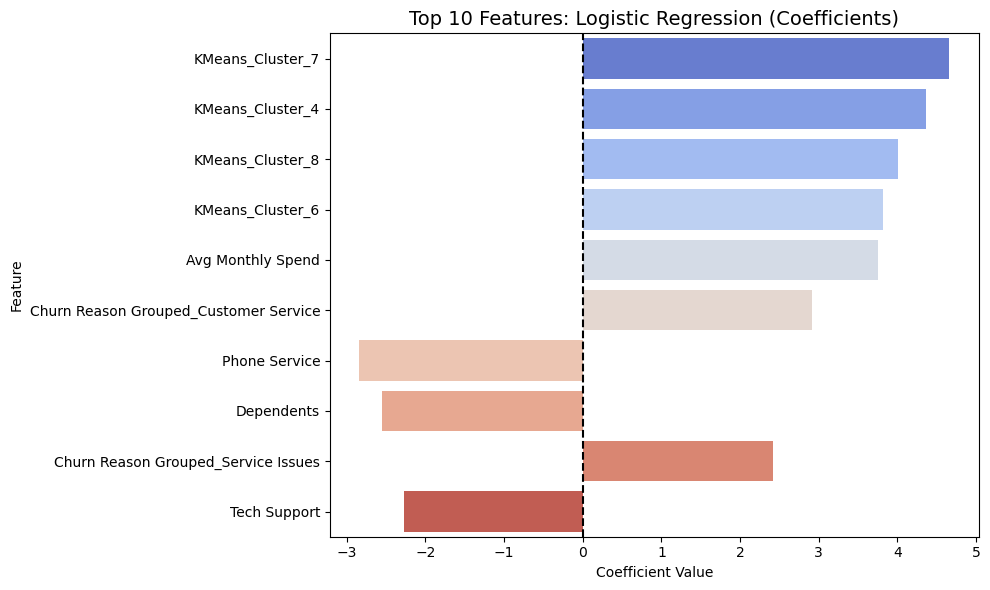

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


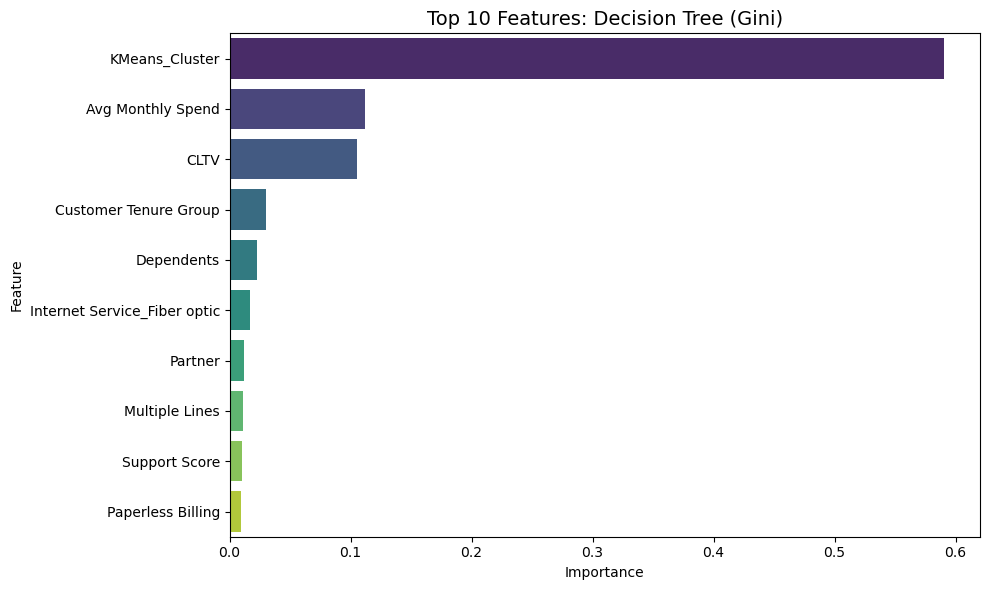

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


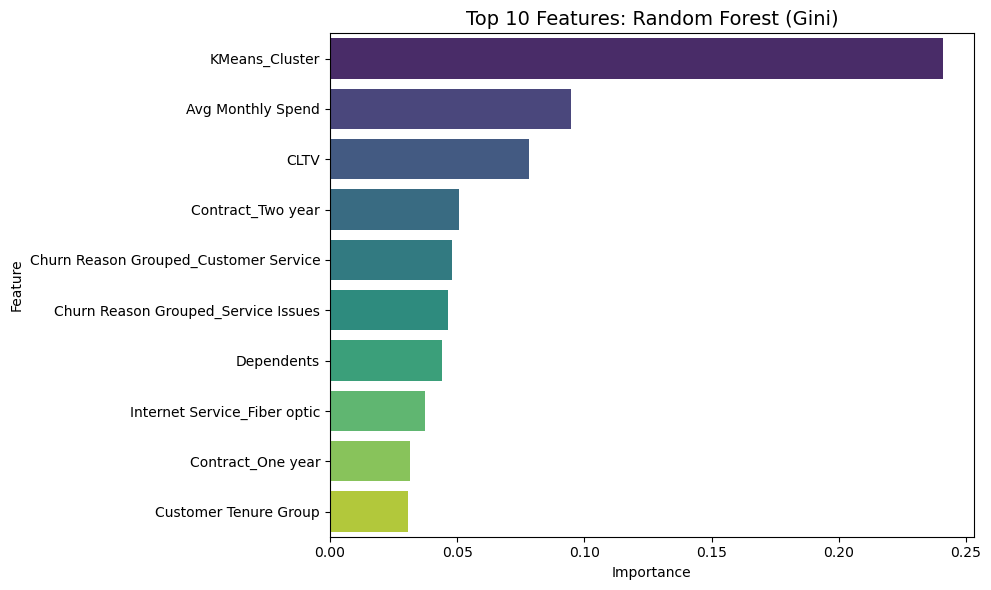

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


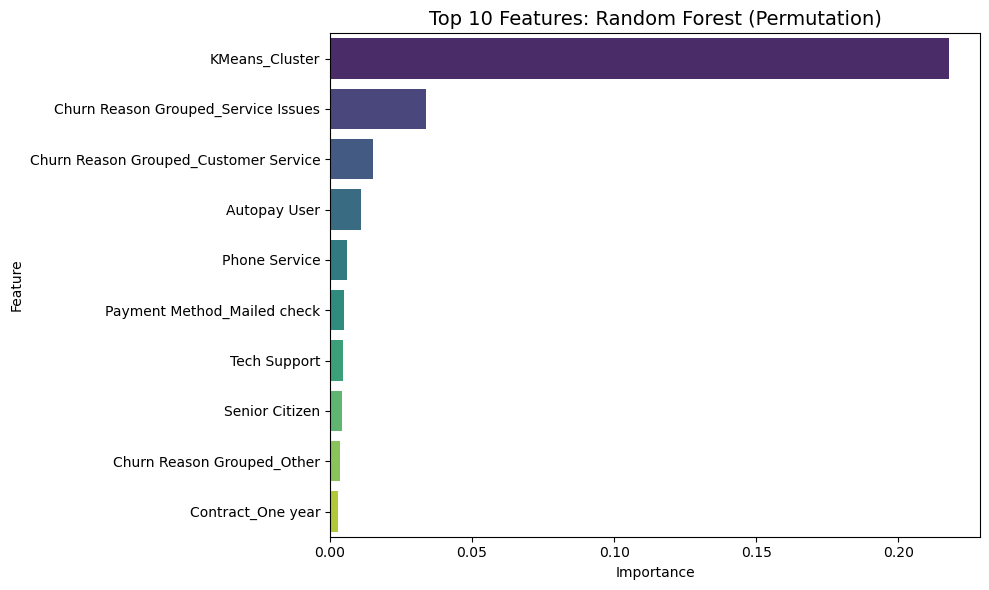

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


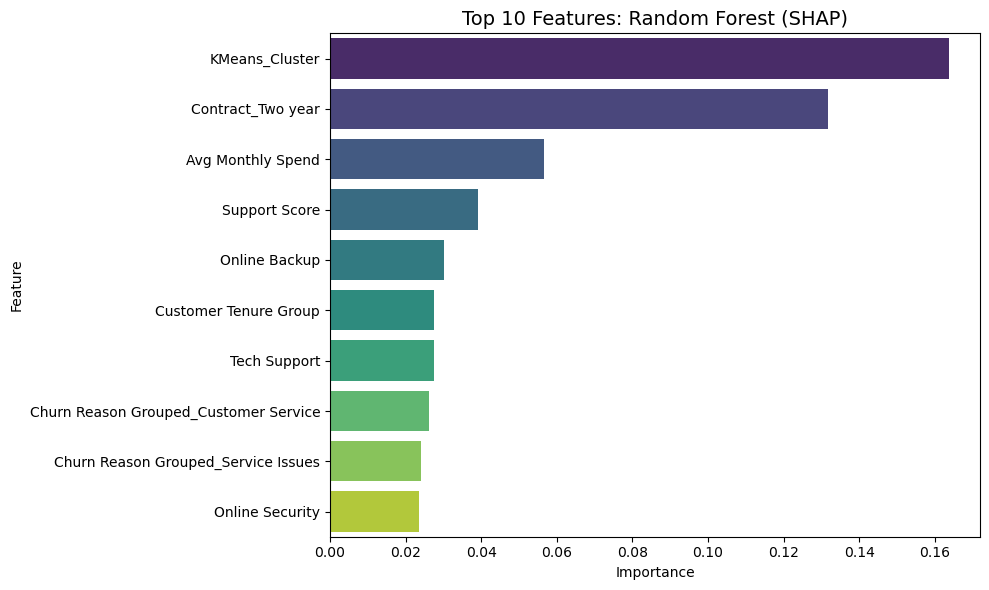

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


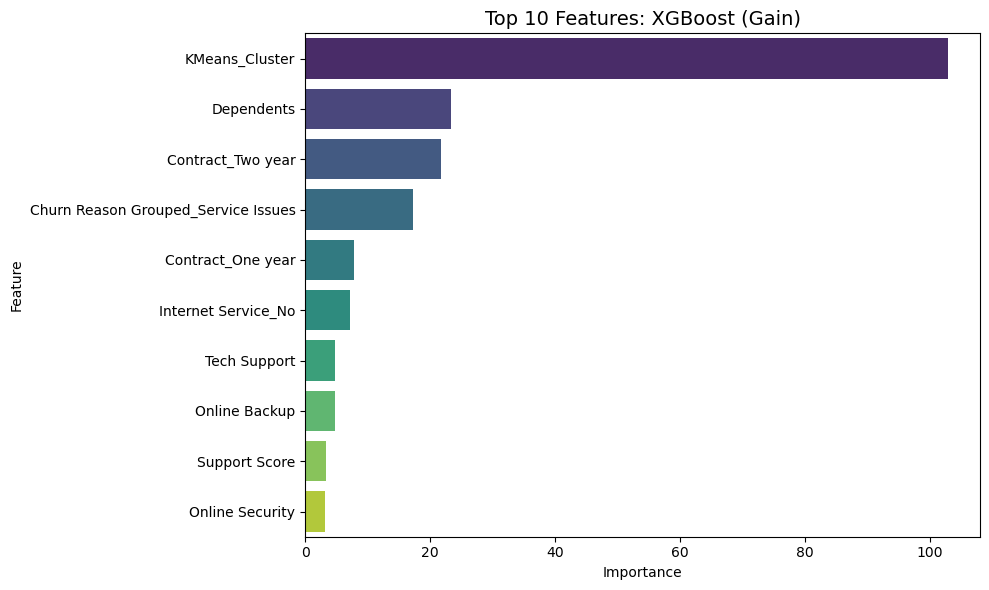

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


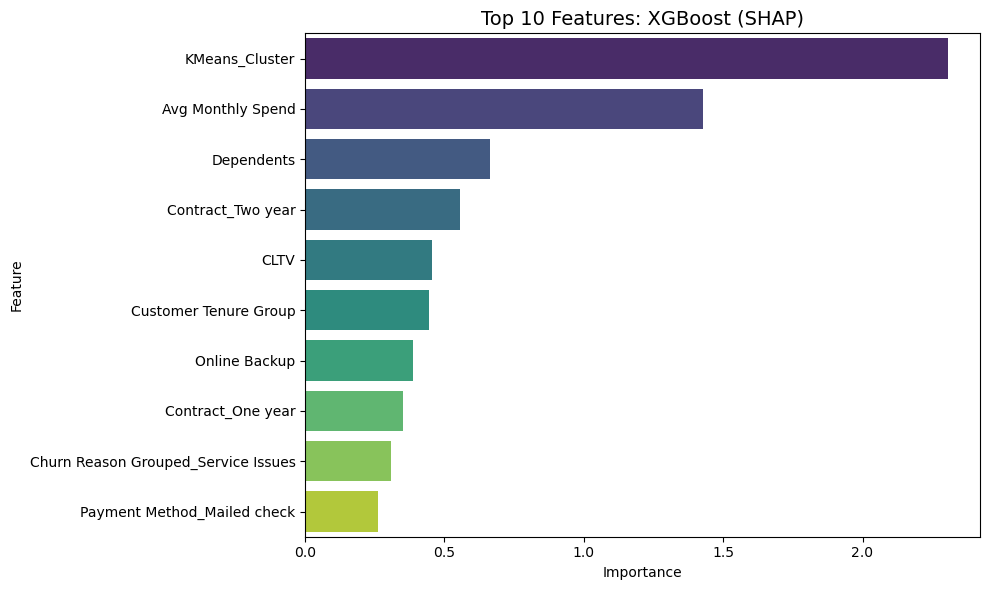

In [36]:
def plot_feature_importance_from_dict(results_dict):
    for model_name, df in results_dict.items():
        plt.figure(figsize=(10, 6))

        signed = 'Logistic Regression' in model_name or 'Coefficients' in model_name
        plot_df = df.copy()
        if not signed:
            plot_df['Importance'] = plot_df['Importance'].abs()

        sns.barplot(
            data=plot_df,
            x='Importance',
            y='Feature',
            palette='coolwarm' if signed else 'viridis'
        )

        if signed:
            plt.axvline(x=0, color='black', linestyle='--')

        plt.title(f'Top 10 Features: {model_name}', fontsize=14)
        plt.xlabel('Coefficient Value' if signed else 'Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

plot_feature_importance_from_dict(top10_trad)

MLP

In [37]:
%pip install -U tf-keras-vis

Note: you may need to restart the kernel to use updated packages.


In [38]:
import tf_keras_vis
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import Score
import warnings

In [39]:
# For reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Build MLP
def build_mlp(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

# Custom score for sigmoid output in IG
class BinarySigmoidScore(Score):
    def __init__(self, target=0):
        self.target = target
    def __call__(self, outputs):
        return outputs[:, self.target]

# Main function
def feature_importance_mlp(X, y):
    set_seeds(42)

    numeric_cols = ['Avg Monthly Spend', 'CLTV']
    X = X.copy()

    # Train-test split
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # One-hot encode KMeans_Cluster
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    train_enc = encoder.fit_transform(X_train_raw[['KMeans_Cluster']])
    test_enc = encoder.transform(X_test_raw[['KMeans_Cluster']])
    cluster_cols = encoder.get_feature_names_out(['KMeans_Cluster'])

    X_train = X_train_raw.drop(columns=['KMeans_Cluster']).reset_index(drop=True)
    X_test = X_test_raw.drop(columns=['KMeans_Cluster']).reset_index(drop=True)

    X_train = pd.concat([X_train, pd.DataFrame(train_enc, columns=cluster_cols)], axis=1)
    X_test = pd.concat([X_test, pd.DataFrame(test_enc, columns=cluster_cols)], axis=1)

    # Scale numeric columns
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    # Train MLP model
    class_weights = dict(enumerate(
        compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    ))

    model = build_mlp(X_train.shape[1])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0, class_weight=class_weights)

    # SHAP DeepExplainer (workaround for Keras models)
    warnings.filterwarnings("ignore", category=UserWarning)

    background = shap.sample(X_train, 100, random_state=42)
    test_sample = shap.sample(X_test, 100, random_state=42)  # smaller set to evaluate

    explainer = shap.DeepExplainer(model, background.values)
    shap_values = explainer.shap_values(test_sample.values)

    # If it's a binary classification, shap_values will be a list
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    if shap_values.ndim == 3 and shap_values.shape[2] == 1:
        shap_values = shap_values.squeeze(-1)

    assert shap_values.shape == test_sample.values.shape, (
        f"Expected SHAP shape {test_sample.values.shape}, got {shap_values.shape}"
    )

    shap_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': np.abs(shap_values).mean(axis=0)
    }).sort_values(by='Importance', ascending=False).head(10)

    # Custom Integrated Gradients
    def integrated_gradients(model, baseline, inputs, steps=50):
        alphas = tf.linspace(0.0, 1.0, steps + 1)
        alphas_x = alphas[:, tf.newaxis, tf.newaxis]  # shape: (steps+1, 1, 1)
        input_diff = inputs - baseline  # shape: (batch_size, num_features)
        interpolated = baseline + alphas_x * input_diff  # shape: (steps+1, batch_size, num_features)

        # Flatten the first dimension for batch processing
        interpolated_2d = tf.reshape(interpolated, ((steps + 1) * inputs.shape[0], inputs.shape[1]))

        with tf.GradientTape() as tape:
            tape.watch(interpolated_2d)
            preds = model(interpolated_2d)

        grads = tape.gradient(preds, interpolated_2d)
        grads = tf.reshape(grads, (steps + 1, inputs.shape[0], inputs.shape[1]))

        avg_grads = tf.reduce_mean(grads[1:], axis=0)  # skip the baseline step
        ig= (inputs - baseline) * avg_grads
        return ig.numpy()

        # Prepare baseline and inputs for Integrated Gradients
    baseline = tf.convert_to_tensor(np.zeros_like(test_sample.values).astype(np.float32))
    inputs = tf.convert_to_tensor(test_sample.values.astype(np.float32))

    ig_values = integrated_gradients(model, baseline, inputs)
    ig_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': np.abs(ig_values).mean(axis=0)
    }).sort_values(by='Importance', ascending=False).head(10)

    return {
        "MLP (SHAP)": shap_df,
        "MLP (Integrated Gradients)": ig_df
    }

In [40]:
top10_mlp1 = feature_importance_mlp(X, y)
top10_mlp1.keys()

dict_keys(['MLP (SHAP)', 'MLP (Integrated Gradients)'])

In [41]:
top10_mlp1['MLP (SHAP)']

,Feature,Importance
15,Customer Tenure Group,0.046150
29,Churn Reason Grouped_Customer Service,0.040608
32,Churn Reason Grouped_Service Issues,0.035156
3,Dependents,0.035061
13,Avg Monthly Spend,0.029472
22,Internet Service_Fiber optic,0.024798
35,KMeans_Cluster_3,0.024354
36,KMeans_Cluster_4,0.023698
40,KMeans_Cluster_8,0.023131
33,KMeans_Cluster_1,0.022488


In [42]:
top10_mlp1['MLP (Integrated Gradients)']

,Feature,Importance
15,Customer Tenure Group,0.118419
4,Phone Service,0.059054
29,Churn Reason Grouped_Customer Service,0.040631
13,Avg Monthly Spend,0.038428
11,Streaming Movies,0.037199
22,Internet Service_Fiber optic,0.036558
32,Churn Reason Grouped_Service Issues,0.034271
12,Paperless Billing,0.030559
10,Streaming TV,0.025197
5,Multiple Lines,0.023842


C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


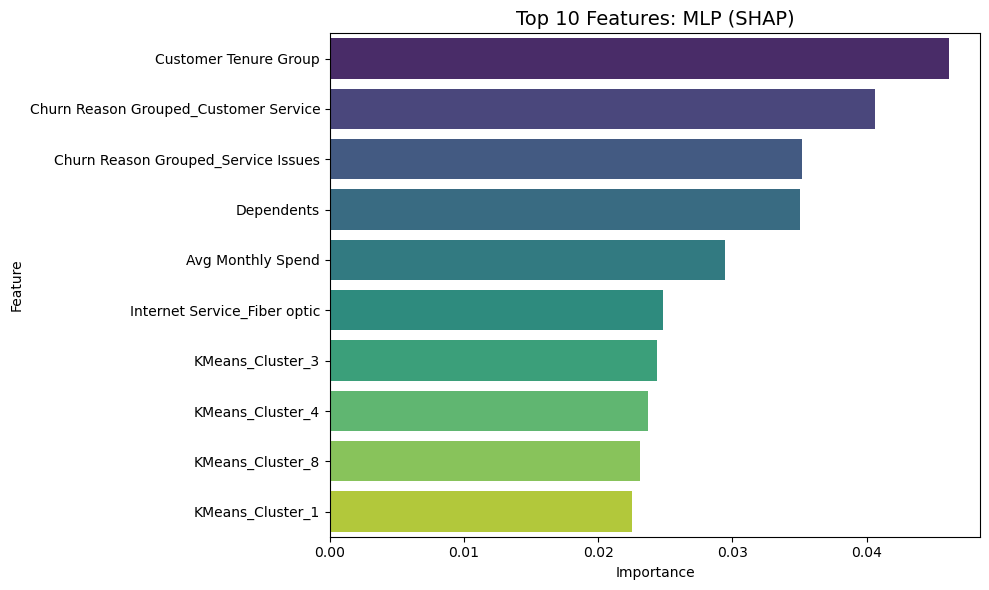

C:\Users\ricar\AppData\Local\Temp\ipykernel_46600\667414474.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


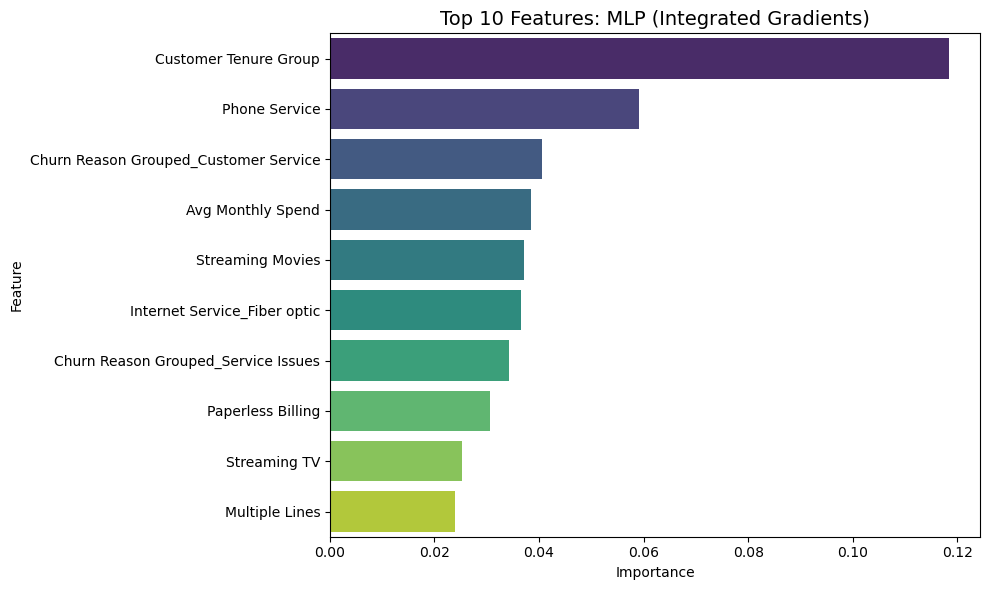

In [43]:
plot_feature_importance_from_dict(top10_mlp1)

# Key Drivers of Churn

K-means clusters consistently emerge as important features across various models, highlighting the need for targeted strategies based on customer segments.

Average monthly spend and CLTV are significant predictors, suggesting that pricing and value perception play a role in churn.

Churn reasons related to customer service and service issues, as well as tech support usage, strongly influence churn.

Contract length and customer tenure are relevant, indicating the impact of commitment and loyalty.

Dependents, autopay usage, and payment methods also contribute to churn prediction.
